**Feb 20**: Run a first pass with 2 training sims, with truncated sequences so that they can be concatenated together in 1 batch. Use a validation sim in the middle of the domain (these are with just 2 parameters, BStrength and iHelicity - so we will fix iHelicity for the 3 runs considered). Use the encoder-decoder setup from the PNODE Paper with modifications to accomodate dimensionality.

In [3]:
runConv=True

In [4]:
import os
import sys
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot
import matplotlib.pyplot as plt

import time
import datetime
import argparse
import numpy as np
import pandas as pd
from random import SystemRandom
import logging

import torch
import torch.nn as nn
from torch.nn.functional import relu
import torch.optim as optim
from torch.utils.data import DataLoader

# import lib.utils as utils
# from lib.plotting import *

# from lib.create_pinode_model import *
# from lib.parse_datasets import parse_datasets
# from lib.ode_func import ODEFunc
# from lib.diffeq_solver import DiffeqSolver
# from lib.node import PNODE_net

# from lib.utils import compute_loss_all_batches

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

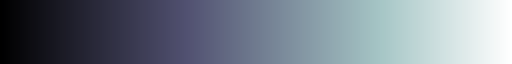

In [6]:
from sunpy.visualization import colormaps as cm
lc3_reg = cm.cmlist['soholasco3']
lc3_reg

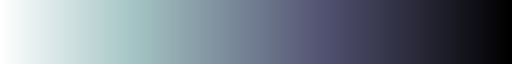

In [7]:
lc3 = cm.cmlist['soholasco3'].reversed()
lc3

In [8]:
%matplotlib inline

In [9]:
adjoint=True
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [10]:
# Generative model for noisy data based on ODE
parser = argparse.ArgumentParser('PNODE')
parser.add_argument('--niters', type=int, default=1000)
parser.add_argument('--lr',  type=float, default=1e-2, help="Starting learning rate.")
# parser.add_argument('-b', '--batch-size', type=int, default=50)

parser.add_argument('--save', type=str, default='experiments/', help="Path for save checkpoints")
parser.add_argument('--load', type=str, 
#                     default=52407,
                    default=None, 
                    help="ID of the experiment to load for evaluation. If None, run a new experiment.")
parser.add_argument('-r', '--random-seed', type=int, default=1991, help="Random_seed")



parser.add_argument('--z0-encoder', type=str, 
                    default='odernn', help="Type of encoder for Latent ODE model: odernn or rnn")
parser.add_argument('--decoder-mlp', action='store_true', help="decoder is mlp")
parser.add_argument('--decoder-mlp-nlayers', type=int, default=1, 
                    help="the number of layers in the decoder MLP")


parser.add_argument('--node-layers', type=int, default=1, help="number of layers in NODE")

parser.add_argument('-l', '--latents', type=int, default=8, help="Size of the latent state")
# parser.add_argument('--params', type=int, default=2, help="number of PDE params")

parser.add_argument('-u', '--units', type=int, default=100, help="Number of units per layer in ODE func")


args = parser.parse_args(args=())

In [11]:
vars(args)

{'niters': 1000,
 'lr': 0.01,
 'save': 'experiments/',
 'load': None,
 'random_seed': 1991,
 'z0_encoder': 'odernn',
 'decoder_mlp': False,
 'decoder_mlp_nlayers': 1,
 'node_layers': 1,
 'latents': 8,
 'units': 100}

In [12]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)

In [13]:
validation_dir = "./validation_data"

In [14]:
validation_file = np.load(os.path.join(validation_dir, "CR2161_validation_PolarTensor.npy"))

In [15]:
validation_file.shape

(128, 512, 90, 23)

In [16]:
sim_file = np.load(os.path.join(validation_dir, "CR2161_SimID4edge_validation.npy"))
sim_file.shape

(23,)

In [17]:
param_file = np.loadtxt(os.path.join(validation_dir, "params_2161_validation.txt"))

In [18]:
param_file

array([[ 5.18  , -1.    ],
       [ 6.7339, -1.    ],
       [ 8.288 , -1.    ],
       [ 9.8419, -1.    ],
       [11.396 , -1.    ],
       [11.7845, -1.    ],
       [12.95  , -1.    ],
       [14.5039, -1.    ],
       [16.058 , -1.    ],
       [17.612 , -1.    ],
       [19.166 , -1.    ],
       [20.72  , -1.    ],
       [ 5.18  ,  1.    ],
       [ 6.7339,  1.    ],
       [ 8.288 ,  1.    ],
       [ 9.8419,  1.    ],
       [11.396 ,  1.    ],
       [11.7845,  1.    ],
       [12.95  ,  1.    ],
       [14.5039,  1.    ],
       [16.058 ,  1.    ],
       [17.612 ,  1.    ],
       [19.166 ,  1.    ],
       [20.72  ,  1.    ]])

In [19]:
sim_file

array(['run001_AWSoM2T_restart_run004_AWSoM2T',
       'run002_AWSoM2T_restart_run004_AWSoM2T',
       'run003_AWSoM2T_restart_run004_AWSoM2T',
       'run004_AWSoM2T_restart_run004_AWSoM2T',
       'run005_AWSoM2T_restart_run004_AWSoM2T',
       'run006_AWSoM2T_restart_run004_AWSoM2T',
       'run007_AWSoM2T_restart_run004_AWSoM2T',
       'run008_AWSoM2T_restart_run004_AWSoM2T',
       'run009_AWSoM2T_restart_run004_AWSoM2T',
       'run010_AWSoM2T_restart_run004_AWSoM2T',
       'run011_AWSoM2T_restart_run004_AWSoM2T',
       'run013_AWSoM2T_restart_run004_AWSoM2T',
       'run014_AWSoM2T_restart_run004_AWSoM2T',
       'run015_AWSoM2T_restart_run004_AWSoM2T',
       'run016_AWSoM2T_restart_run004_AWSoM2T',
       'run017_AWSoM2T_restart_run004_AWSoM2T',
       'run018_AWSoM2T_restart_run004_AWSoM2T',
       'run019_AWSoM2T_restart_run004_AWSoM2T',
       'run020_AWSoM2T_restart_run004_AWSoM2T',
       'run021_AWSoM2T_restart_run004_AWSoM2T',
       'run022_AWSoM2T_restart_run004_AW

In [20]:
all_sim_ids = np.linspace(1, 24, 24, dtype=int)
available_sim_ids = np.setdiff1d(all_sim_ids, np.array([12]))
available_sim_ids

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24])

In [21]:
train_idx = np.array([12, 22])
val_idx = np.array([17]) # used to check losses and checkpoint the model
test_idx = np.array([14]) # only used once model is built.

In [22]:
available_sim_ids[train_idx], available_sim_ids[val_idx], available_sim_ids[test_idx]

(array([14, 24]), array([19]), array([16]))

In [23]:
train_params_raw = param_file[available_sim_ids[train_idx] - 1, :]
val_params_raw = param_file[available_sim_ids[val_idx] - 1, :]
test_params_raw = param_file[available_sim_ids[test_idx] - 1, :]

train_params_raw, val_params_raw, test_params_raw

(array([[ 6.7339,  1.    ],
        [20.72  ,  1.    ]]),
 array([[12.95,  1.  ]]),
 array([[9.8419, 1.    ]]))

In [24]:
train_raw = validation_file[:, :, :, train_idx]
val_raw = validation_file[:, :, :, val_idx]
test_raw = validation_file[:, :, :, test_idx]
train_raw.shape, val_raw.shape

((128, 512, 90, 2), (128, 512, 90, 1))

In [25]:
all_timesteps = np.linspace(2, 180, 90, dtype=int)

In [26]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
# plt.style.use("dark_background")

In [27]:
# time_idx_to_plot = [0, 20, 40, 50, 60, 80, -1]
# qoi_idx = 1

# fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(10, 14))

# for row in range(7):
#     im = axs[row, 0].imshow(train_raw[:, :, time_idx_to_plot[row], 0],
#                            origin="lower",
#                            cmap=lc3_reg,
#                            )
#     plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 0])
#     axs[row, 0].set_title("Train Sim 1 t = {:02d}".format(all_timesteps[time_idx_to_plot[row]]))
      

# for row in range(7):
#     im = axs[row, 1].imshow(train_raw[:, :, time_idx_to_plot[row], 1],
#                            origin="lower",
#                            cmap=lc3_reg,
#                            )
#     plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 1])
#     axs[row, 1].set_title("Train Sim 2 t = {:02d}".format(all_timesteps[time_idx_to_plot[row]]))
    
    
# for row in range(7):
#     im = axs[row, 2].imshow(val_raw[:, :, time_idx_to_plot[row], 0],
#                            origin="lower",
#                            cmap=lc3_reg,
#                            )
#     plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 2])
#     axs[row, 2].set_title("Validation Sim t = {:02d}".format(all_timesteps[time_idx_to_plot[row]]))

# fig.suptitle("Raw Data")
# fig.tight_layout()

In [28]:
# time_idx_to_plot = [50, 55, 60, 65, 75, 80, -1]
# qoi_idx = 1

# fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(10, 14))

# for row in range(7):
#     im = axs[row, 0].imshow(train_raw[:, :, time_idx_to_plot[row], 0],
#                            origin="lower",
#                            cmap=lc3_reg,
#                            )
#     plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 0])
#     axs[row, 0].set_title("Train Sim 1 t = {:02d}".format(all_timesteps[time_idx_to_plot[row]]))
      

# for row in range(7):
#     im = axs[row, 1].imshow(train_raw[:, :, time_idx_to_plot[row], 1],
#                            origin="lower",
#                            cmap=lc3_reg,
#                            )
#     plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 1])
#     axs[row, 1].set_title("Train Sim 2 t = {:02d}".format(all_timesteps[time_idx_to_plot[row]]))
    
    
# for row in range(7):
#     im = axs[row, 2].imshow(val_raw[:, :, time_idx_to_plot[row], 0],
#                            origin="lower",
#                            cmap=lc3_reg,
#                            )
#     plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 2])
#     axs[row, 2].set_title("Validation Sim t = {:02d}".format(all_timesteps[time_idx_to_plot[row]]))

# fig.suptitle("Raw Data")
# fig.tight_layout()

In [29]:
print(train_raw.min(), train_raw.max())
print(val_raw.min(), val_raw.max())

0.0 1.5
0.0 1.5


Finally, plot on a common colorscale to see the differences very clearly.

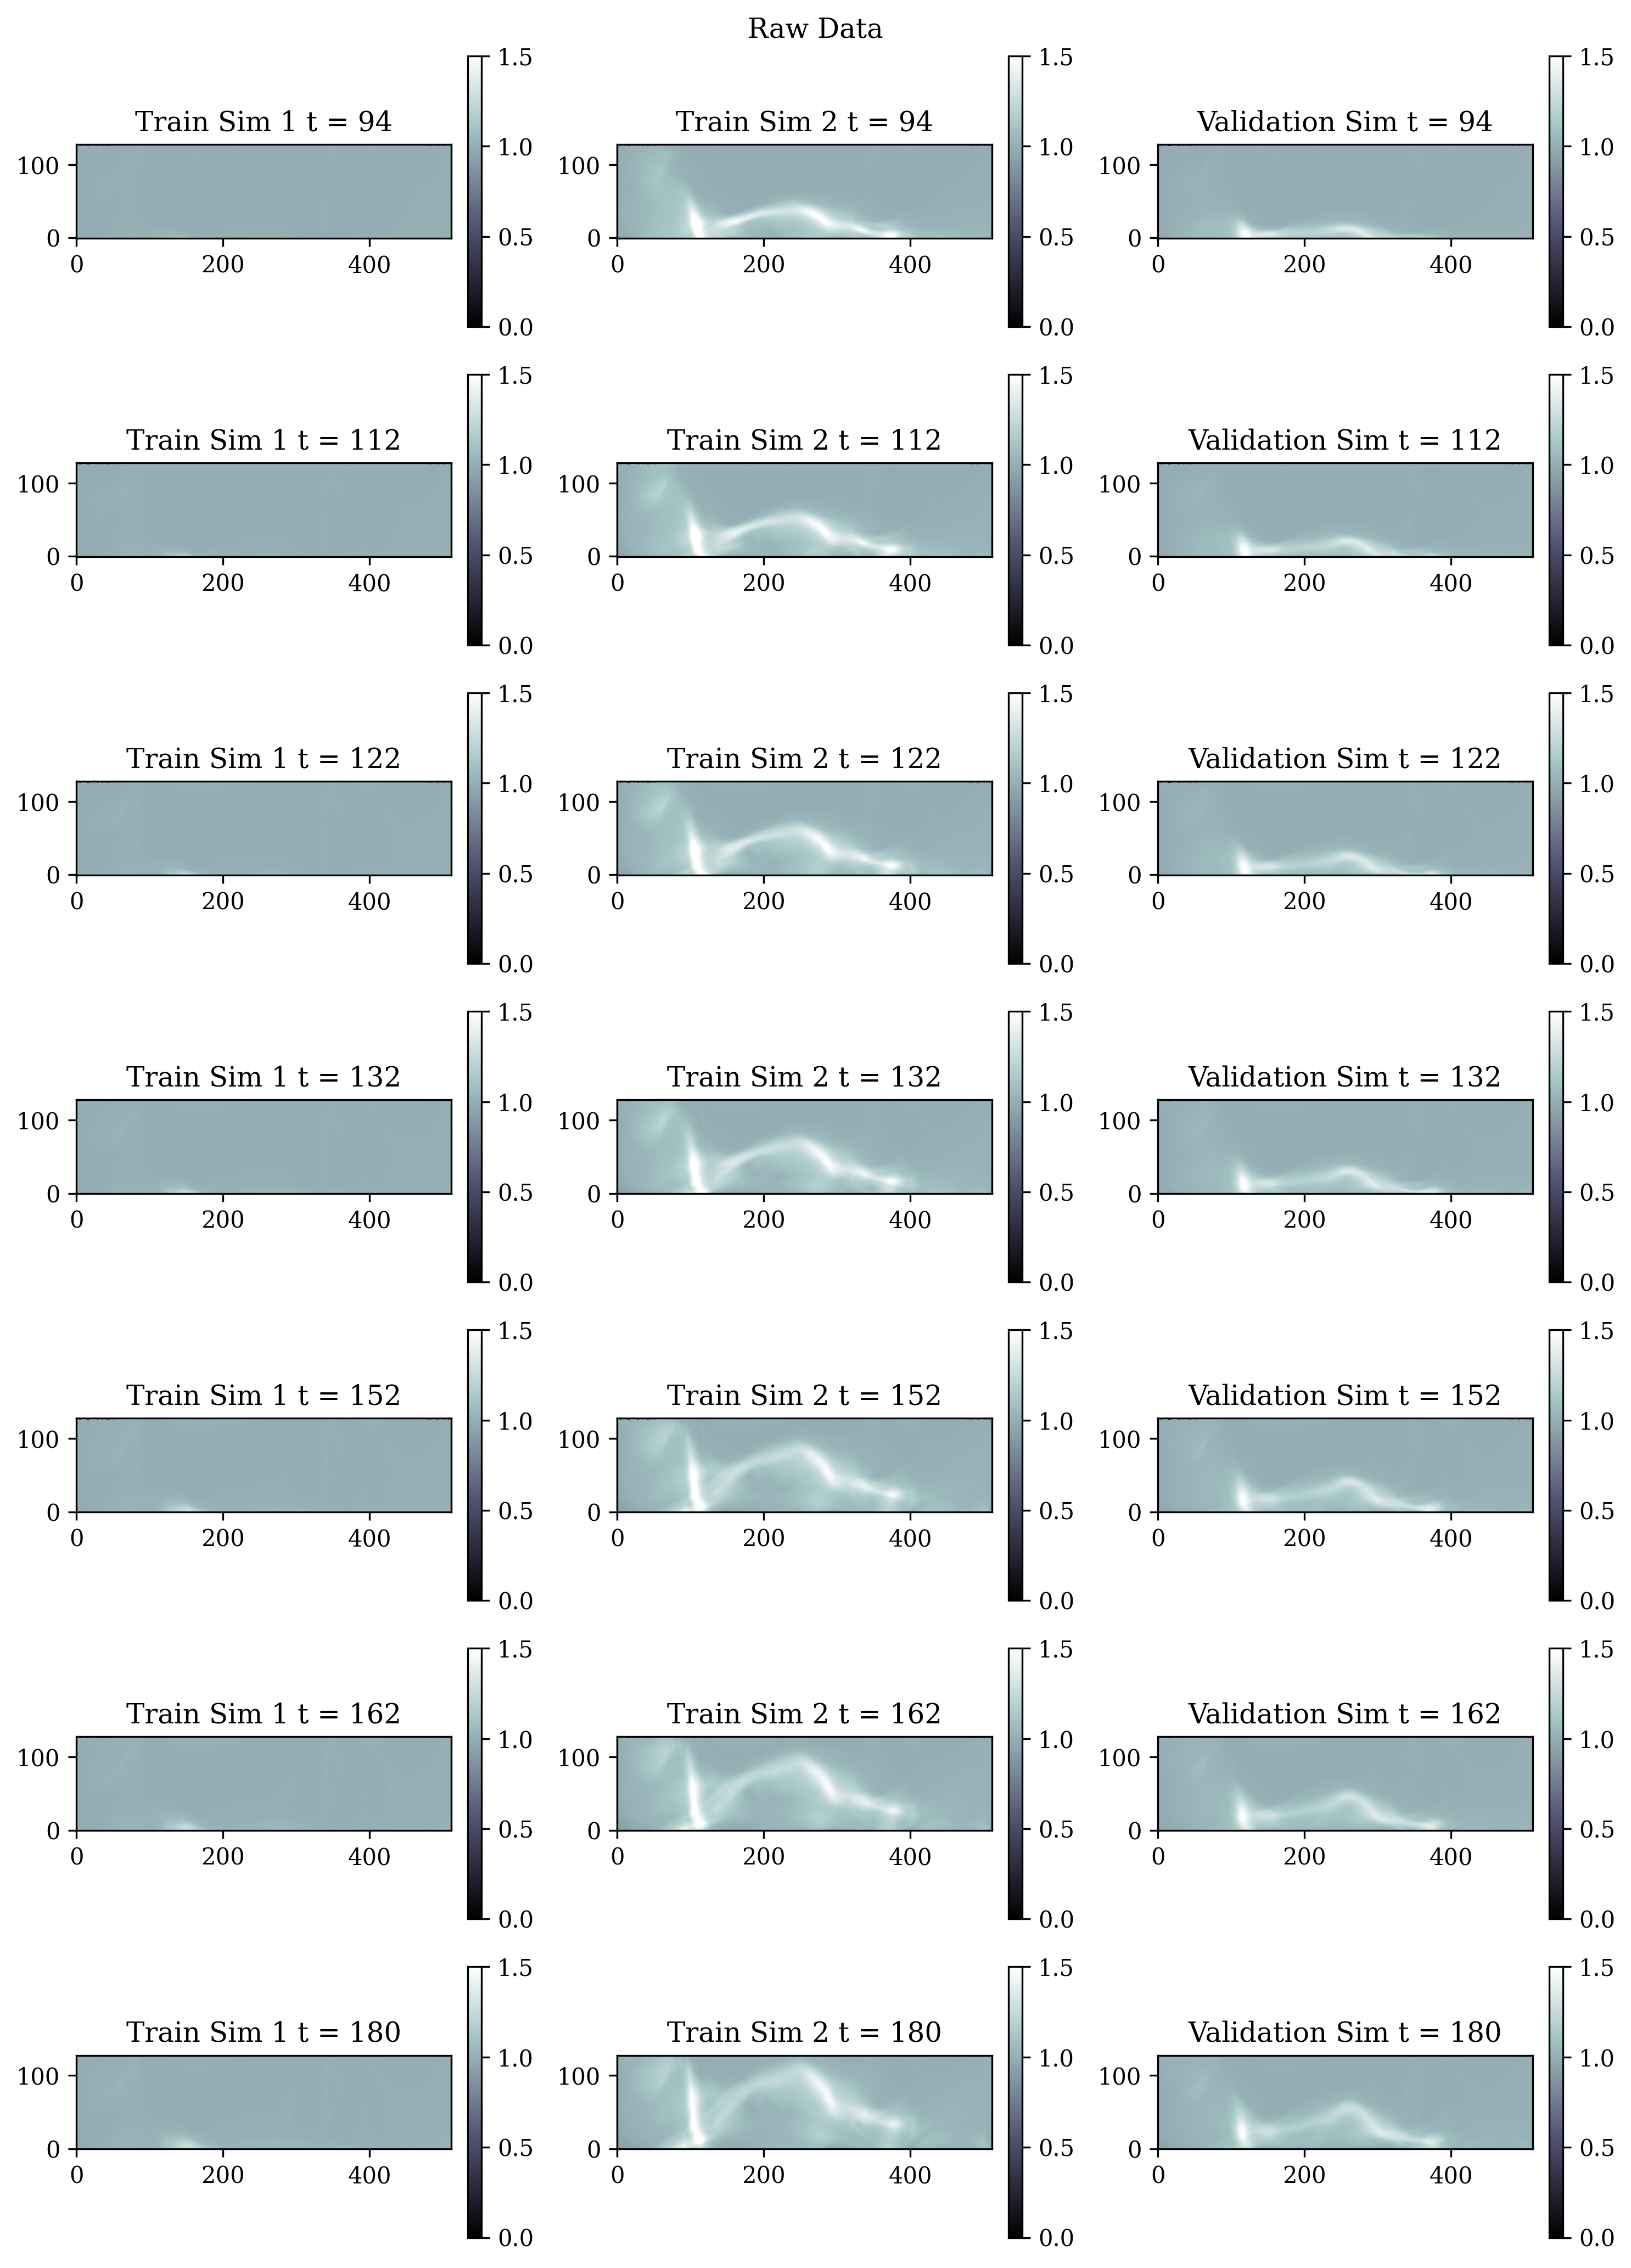

In [30]:
time_idx_to_plot = [46, 55, 60, 65, 75, 80, -1]
qoi_idx = 1

fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(10, 14))

for row in range(7):
    im = axs[row, 0].imshow(train_raw[:, :, time_idx_to_plot[row], 0],
                           origin="lower",
                           cmap=lc3_reg,
                           vmin=0,
                            vmax=1.5
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 0])
    axs[row, 0].set_title("Train Sim 1 t = {:02d}".format(all_timesteps[time_idx_to_plot[row]]))
      

for row in range(7):
    im = axs[row, 1].imshow(train_raw[:, :, time_idx_to_plot[row], 1],
                           origin="lower",
                           cmap=lc3_reg,
                            vmin=0,
                            vmax=1.5
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 1])
    axs[row, 1].set_title("Train Sim 2 t = {:02d}".format(all_timesteps[time_idx_to_plot[row]]))
    
    
for row in range(7):
    im = axs[row, 2].imshow(val_raw[:, :, time_idx_to_plot[row], 0],
                           origin="lower",
                           cmap=lc3_reg,
                            vmin=0,
                            vmax=1.5
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 2])
    axs[row, 2].set_title("Validation Sim t = {:02d}".format(all_timesteps[time_idx_to_plot[row]]))

fig.suptitle("Raw Data")
fig.tight_layout()

In [31]:
all_timesteps[[42, 55, 60, 65, 75, 80, -1]]

array([ 86, 112, 122, 132, 152, 162, 180])

Only for faster testing purposes: Fix a common starting and ending point. In reality, we can train with variable length sequences, but we don't for speedup purposes (easy batching with dataloaders)

In [32]:
tMinIdx = 46
tMaxIdx = len(all_timesteps) - 1
tMinIdx, tMaxIdx

(46, 89)

In [33]:
yTrainMinRaw = train_raw[:, :, tMinIdx:(tMaxIdx + 1), :].min()
yTrainMaxRaw = train_raw[:, :, tMinIdx:(tMaxIdx + 1), :].max()

yTrainMinRaw, yTrainMaxRaw

(0.0, 1.5)

In [34]:
np.argwhere(train_raw[:126, :, :, 1] == 0)

array([], shape=(0, 3), dtype=int64)

In [35]:
np.argwhere(train_raw[:126, :, tMaxIdx, 1] == 1.5)

array([[  8, 108],
       [  8, 111],
       [  8, 112],
       [  8, 113],
       [  8, 114],
       [  9, 107],
       [  9, 108],
       [  9, 109],
       [  9, 110],
       [  9, 111],
       [  9, 112],
       [  9, 113],
       [ 10, 106],
       [ 10, 107],
       [ 10, 108],
       [ 10, 109],
       [ 10, 110],
       [ 10, 111],
       [ 10, 112],
       [ 10, 113],
       [ 10, 114],
       [ 10, 115],
       [ 11, 108],
       [ 11, 109],
       [ 11, 110],
       [ 11, 111],
       [ 11, 112],
       [ 11, 113],
       [ 11, 114],
       [ 11, 115],
       [ 12, 107],
       [ 12, 108],
       [ 12, 109],
       [ 12, 110],
       [ 12, 111],
       [ 12, 112],
       [ 12, 113],
       [ 12, 114],
       [ 12, 115],
       [ 12, 116],
       [ 13, 107],
       [ 13, 108],
       [ 13, 109],
       [ 13, 110],
       [ 13, 111],
       [ 13, 112],
       [ 13, 113],
       [ 13, 114],
       [ 13, 115],
       [ 13, 116],
       [ 13, 117],
       [ 14, 109],
       [ 14,

In [36]:
np.argwhere(train_raw[:126, :, :, 0] == 0)

array([], shape=(0, 3), dtype=int64)

In [37]:
np.argwhere(val_raw[:128, :, :, 0] == 0)

array([[126,   4,   0],
       [126,   4,   1],
       [126,   4,   2],
       ...,
       [127, 511,  87],
       [127, 511,  88],
       [127, 511,  89]])

In [38]:
np.argwhere(test_raw[:126, :, :, :] == 0), np.argwhere(test_raw[:128, :, :, :] == 0)

(array([], shape=(0, 4), dtype=int64),
 array([[126,   4,   0,   0],
        [126,   4,   1,   0],
        [126,   4,   2,   0],
        ...,
        [127, 511,  87,   0],
        [127, 511,  88,   0],
        [127, 511,  89,   0]]))

In [39]:
train_raw[:126, :, tMinIdx:(tMaxIdx + 1), :].min()

0.9175531085896761

In [40]:
train_raw[:126, :, tMinIdx:(tMaxIdx + 1), :].max()

1.5

It looks like the interpolation from the original coordinates has resulted in a row of zero values for the last two rows in the $r$ direction, and we don't want this because its not a true value of intensity, rather its an artifact of the FOV of the coronagraph. Therefore, we will REMOVE the last two rows, and normalize according to these values. Also reverse the colormap for a better viz?

In [41]:
train_raw_actual = train_raw[:126, :, :, :]
val_raw_actual = val_raw[:126, :, :, :]
test_raw_actual = test_raw[:126, :, :, :]

In [42]:
train_raw_actual.shape

(126, 512, 90, 2)

In [43]:
print(train_raw_actual.min(), train_raw_actual.max())
print(val_raw_actual.min(), val_raw_actual.max())

0.9175531085896761 1.5
0.94958776054333 1.5


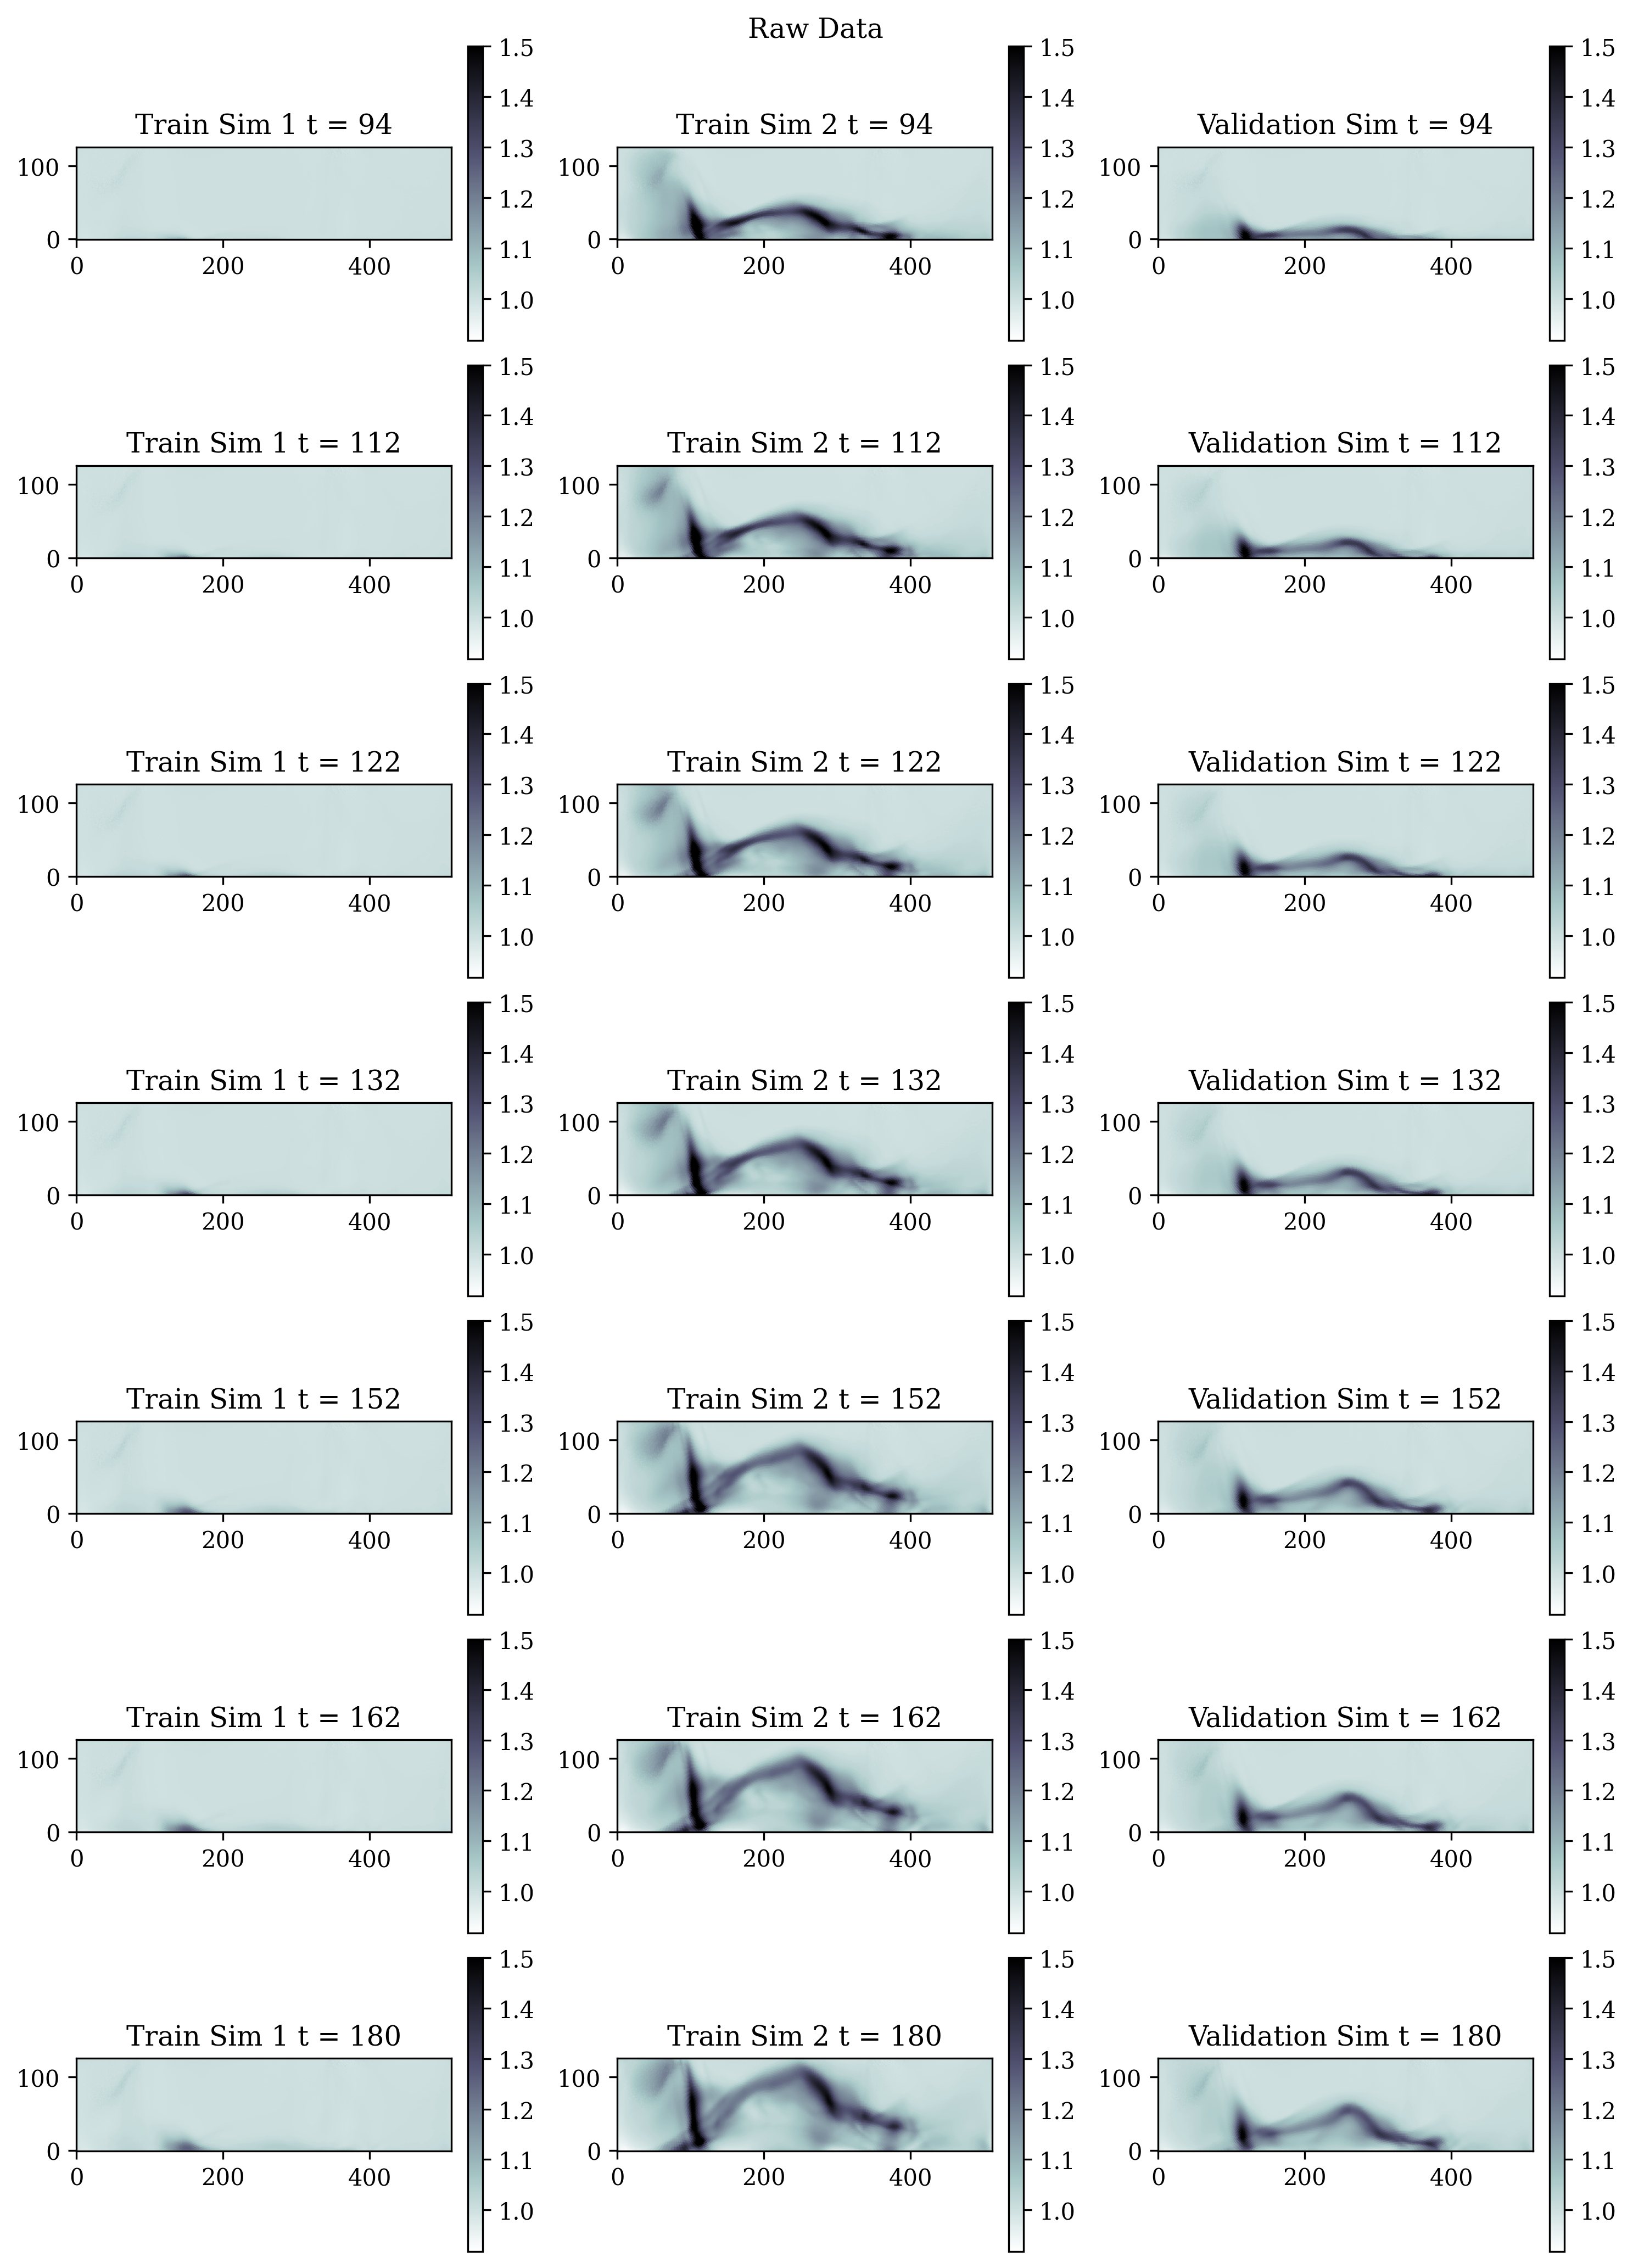

In [44]:
time_idx_to_plot = [46, 55, 60, 65, 75, 80, -1]
qoi_idx = 1

fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(10, 14))

for row in range(7):
    im = axs[row, 0].imshow(train_raw_actual[:, :, time_idx_to_plot[row], 0],
                           origin="lower",
                           cmap=lc3,
                           vmin=train_raw_actual.min(),
                           vmax=1.5
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 0])
    axs[row, 0].set_title("Train Sim 1 t = {:02d}".format(all_timesteps[time_idx_to_plot[row]]))
      

for row in range(7):
    im = axs[row, 1].imshow(train_raw_actual[:, :, time_idx_to_plot[row], 1],
                           origin="lower",
                           cmap=lc3,
                            vmin=train_raw_actual.min(),
                            vmax=1.5
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 1])
    axs[row, 1].set_title("Train Sim 2 t = {:02d}".format(all_timesteps[time_idx_to_plot[row]]))
    
    
for row in range(7):
    im = axs[row, 2].imshow(val_raw_actual[:, :, time_idx_to_plot[row], 0],
                           origin="lower",
                           cmap=lc3,
                            vmin=train_raw_actual.min(),
                            vmax=1.5
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 2])
    axs[row, 2].set_title("Validation Sim t = {:02d}".format(all_timesteps[time_idx_to_plot[row]]))

fig.suptitle("Raw Data")
fig.tight_layout()

Downsample the images appropriately. Then normalize all the data based on the training values scales, and normalize parameter values so they are on a comparable scale too!

In [45]:
32 * 128

4096

In [46]:
import torchvision
import torchvision.transforms as T

resize_dims = (32, 128)

In [47]:
train_raw_actual.shape, val_raw_actual.shape, test_raw_actual.shape

((126, 512, 90, 2), (126, 512, 90, 1), (126, 512, 90, 1))

In [48]:
torch.Tensor(train_raw_actual.transpose(3, 2, 0, 1)).shape

torch.Size([2, 90, 126, 512])

In [49]:
train_raw_resized_permuted = T.Resize(size=resize_dims, 
                                      antialias=True)(torch.Tensor(train_raw_actual.transpose(3, 2, 0, 1)))

val_raw_resized_permuted = T.Resize(size=resize_dims, 
                                      antialias=True)(torch.Tensor(val_raw_actual.transpose(3, 2, 0, 1)))

test_raw_resized_permuted = T.Resize(size=resize_dims, 
                                      antialias=True)(torch.Tensor(test_raw_actual.transpose(3, 2, 0, 1)))


train_raw_resized_permuted.shape, val_raw_resized_permuted.shape, test_raw_resized_permuted.shape

(torch.Size([2, 90, 32, 128]),
 torch.Size([1, 90, 32, 128]),
 torch.Size([1, 90, 32, 128]))

Check min, max values, plot to visually confirm.

In [50]:
train_raw_resized_permuted.min(), train_raw_resized_permuted.max()

(tensor(0.9298), tensor(1.5000))

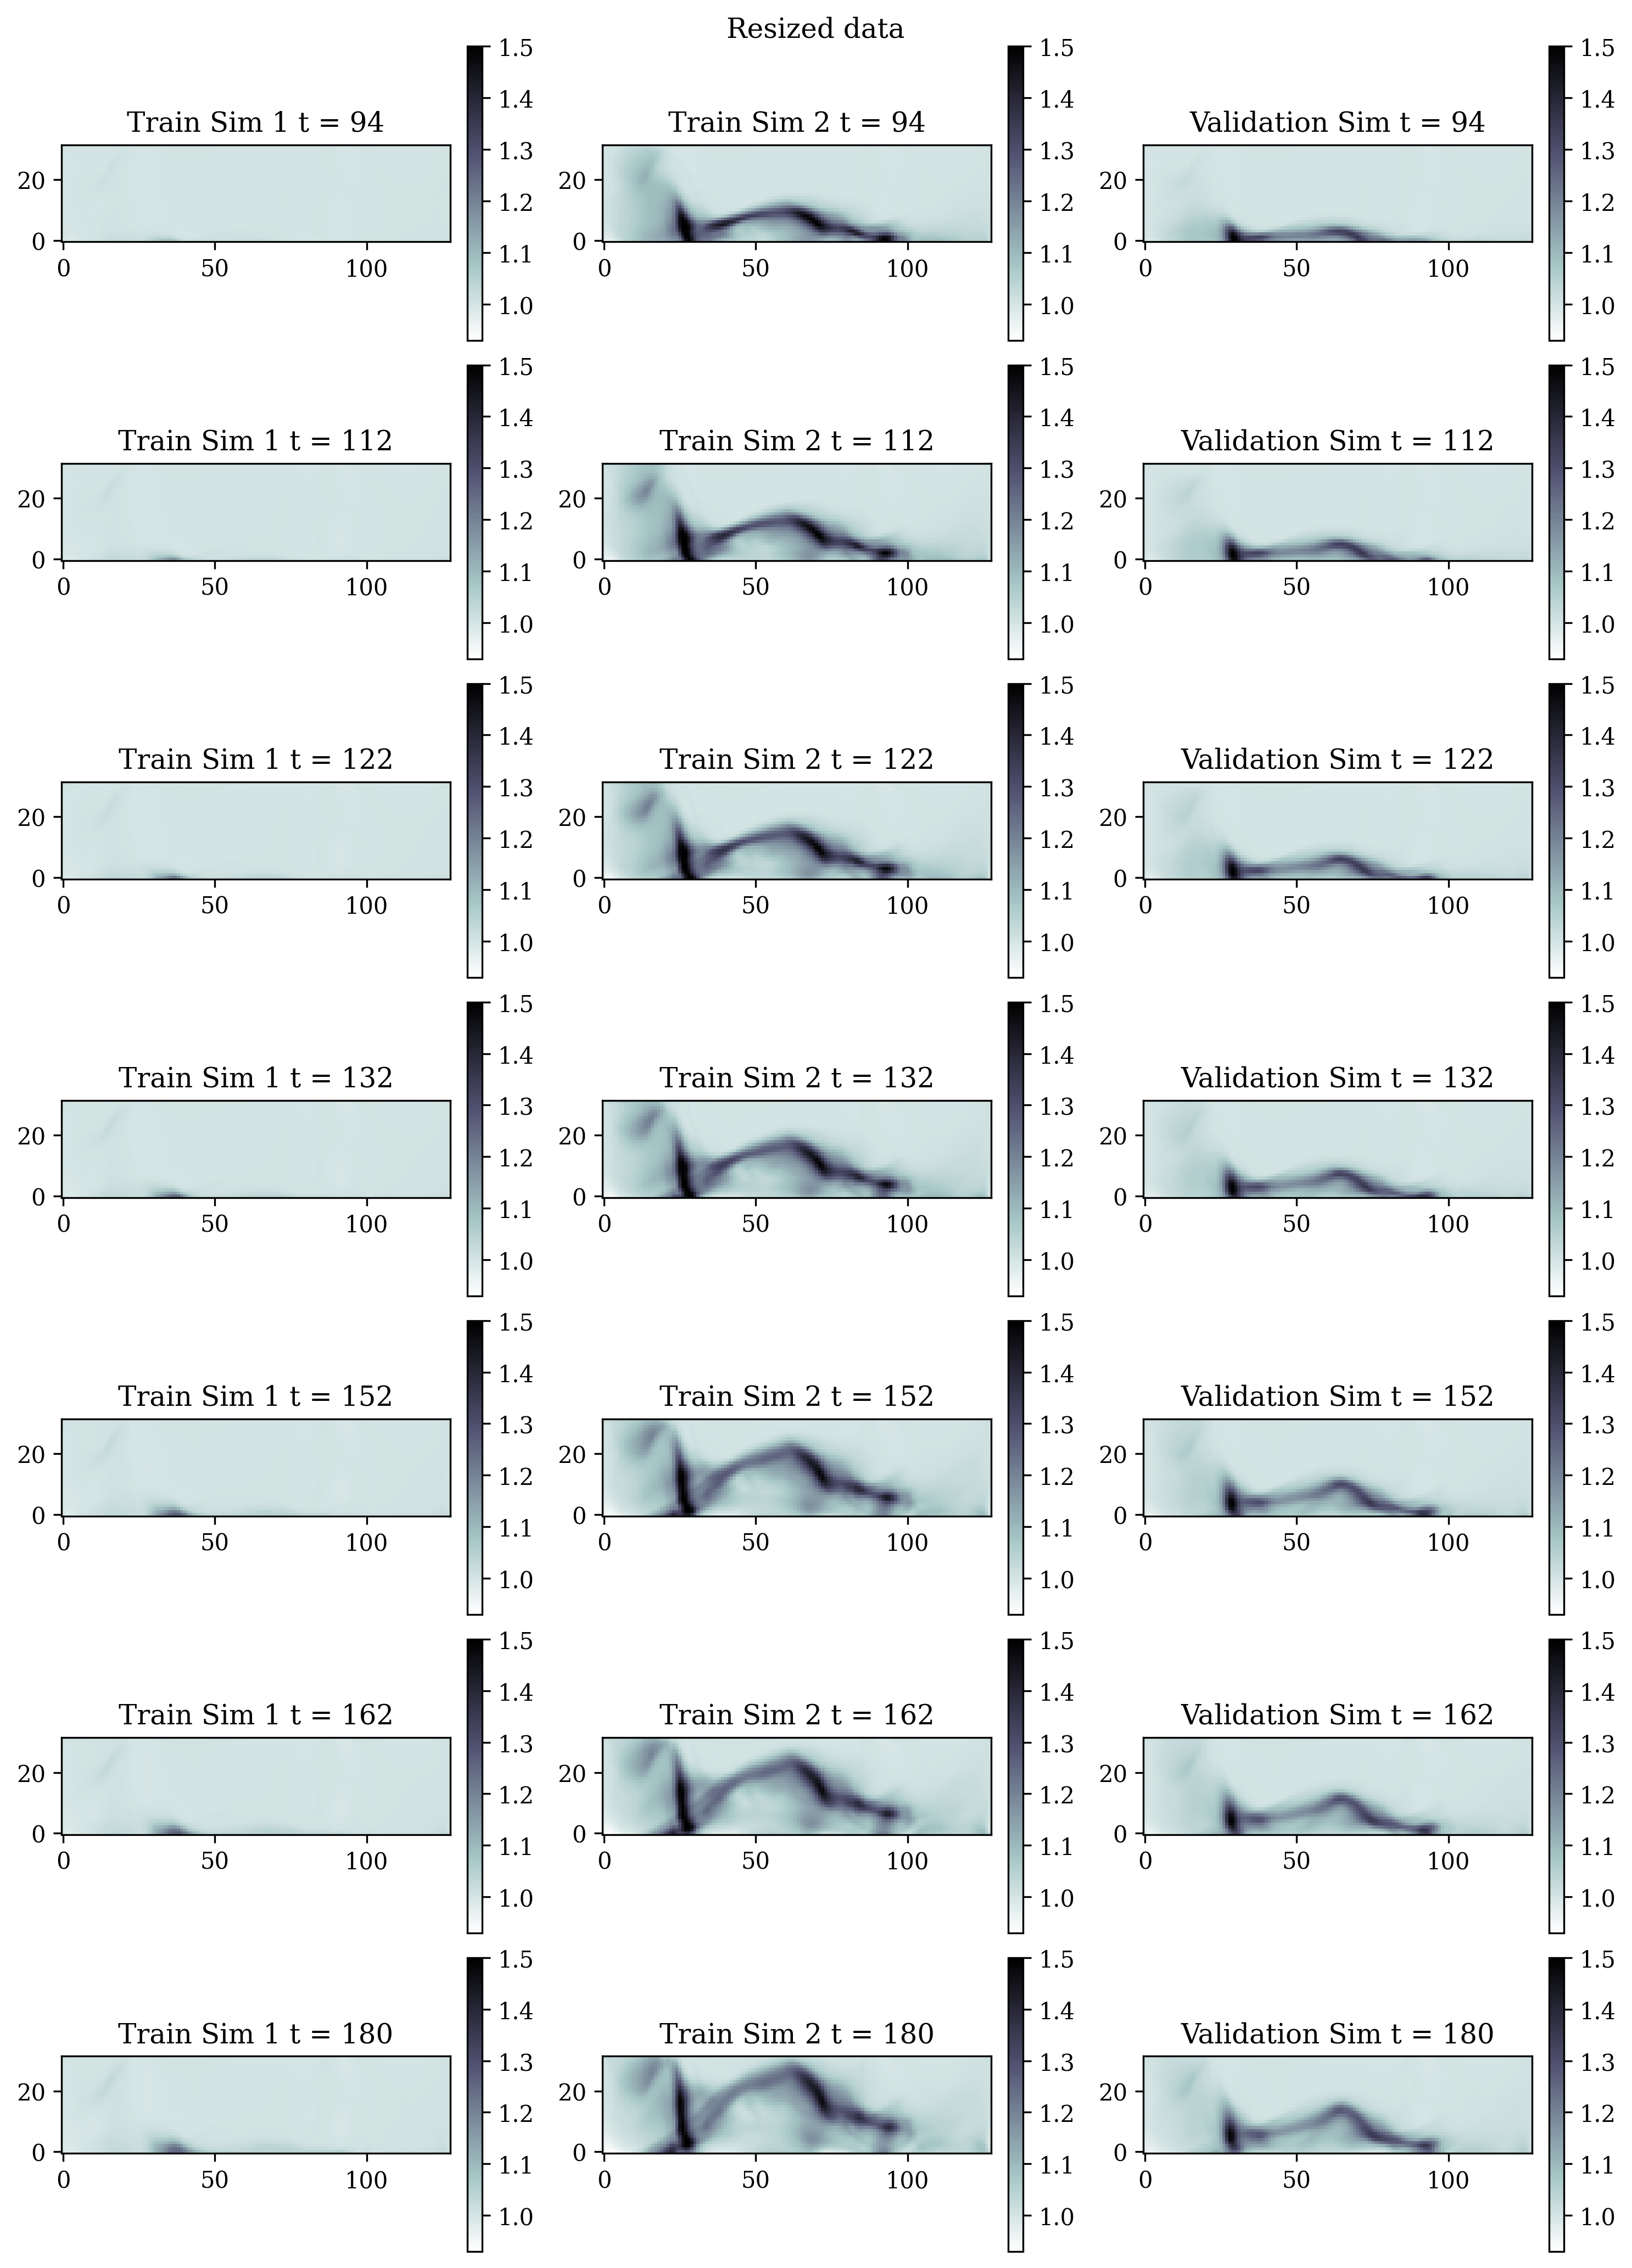

In [51]:
time_idx_to_plot = [46, 55, 60, 65, 75, 80, -1]
qoi_idx = 1

fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(10, 14))

for row in range(7):
    im = axs[row, 0].imshow(train_raw_resized_permuted[0, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=train_raw_resized_permuted.min(),
                           vmax=1.5
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 0])
    axs[row, 0].set_title("Train Sim 1 t = {:02d}".format(all_timesteps[time_idx_to_plot[row]]))
      

for row in range(7):
    im = axs[row, 1].imshow(train_raw_resized_permuted[1, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                            vmin=train_raw_resized_permuted.min(),
                            vmax=1.5
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 1])
    axs[row, 1].set_title("Train Sim 2 t = {:02d}".format(all_timesteps[time_idx_to_plot[row]]))
    
    
for row in range(7):
    im = axs[row, 2].imshow(val_raw_resized_permuted[0, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                            vmin=train_raw_resized_permuted.min(),
                            vmax=1.5
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 2])
    axs[row, 2].set_title("Validation Sim t = {:02d}".format(all_timesteps[time_idx_to_plot[row]]))

fig.suptitle("Resized data")
fig.tight_layout()

Now scale data, and replot with new min-max values for cmap

In [52]:
trainMin = train_raw_resized_permuted[:, tMinIdx:(tMaxIdx + 1), :, :].min()
trainMax = train_raw_resized_permuted[:, tMinIdx:(tMaxIdx + 1), :, :].max()

In [53]:
train_raw_scaled = (train_raw_resized_permuted[:, tMinIdx:(tMaxIdx + 1), :, :] - trainMin) / (trainMax - trainMin)
val_raw_scaled = (val_raw_resized_permuted[:, tMinIdx:(tMaxIdx + 1), :, :] - trainMin) / (trainMax - trainMin)
test_raw_scaled = (test_raw_resized_permuted[:, tMinIdx:(tMaxIdx + 1), :, :] - trainMin) / (trainMax - trainMin)

In [54]:
train_raw_scaled.shape, val_raw_scaled.shape

(torch.Size([2, 44, 32, 128]), torch.Size([1, 44, 32, 128]))

In [55]:
tt = np.linspace(0, 1, tMaxIdx - tMinIdx + 1)
tpredict = torch.Tensor(tt).to(device)
tpredict.shape

torch.Size([44])

In [56]:
print(train_raw_scaled.min(), train_raw_scaled.max())
print(val_raw_scaled.min(), val_raw_scaled.max())

tensor(0.) tensor(1.)
tensor(0.0495) tensor(0.9956)


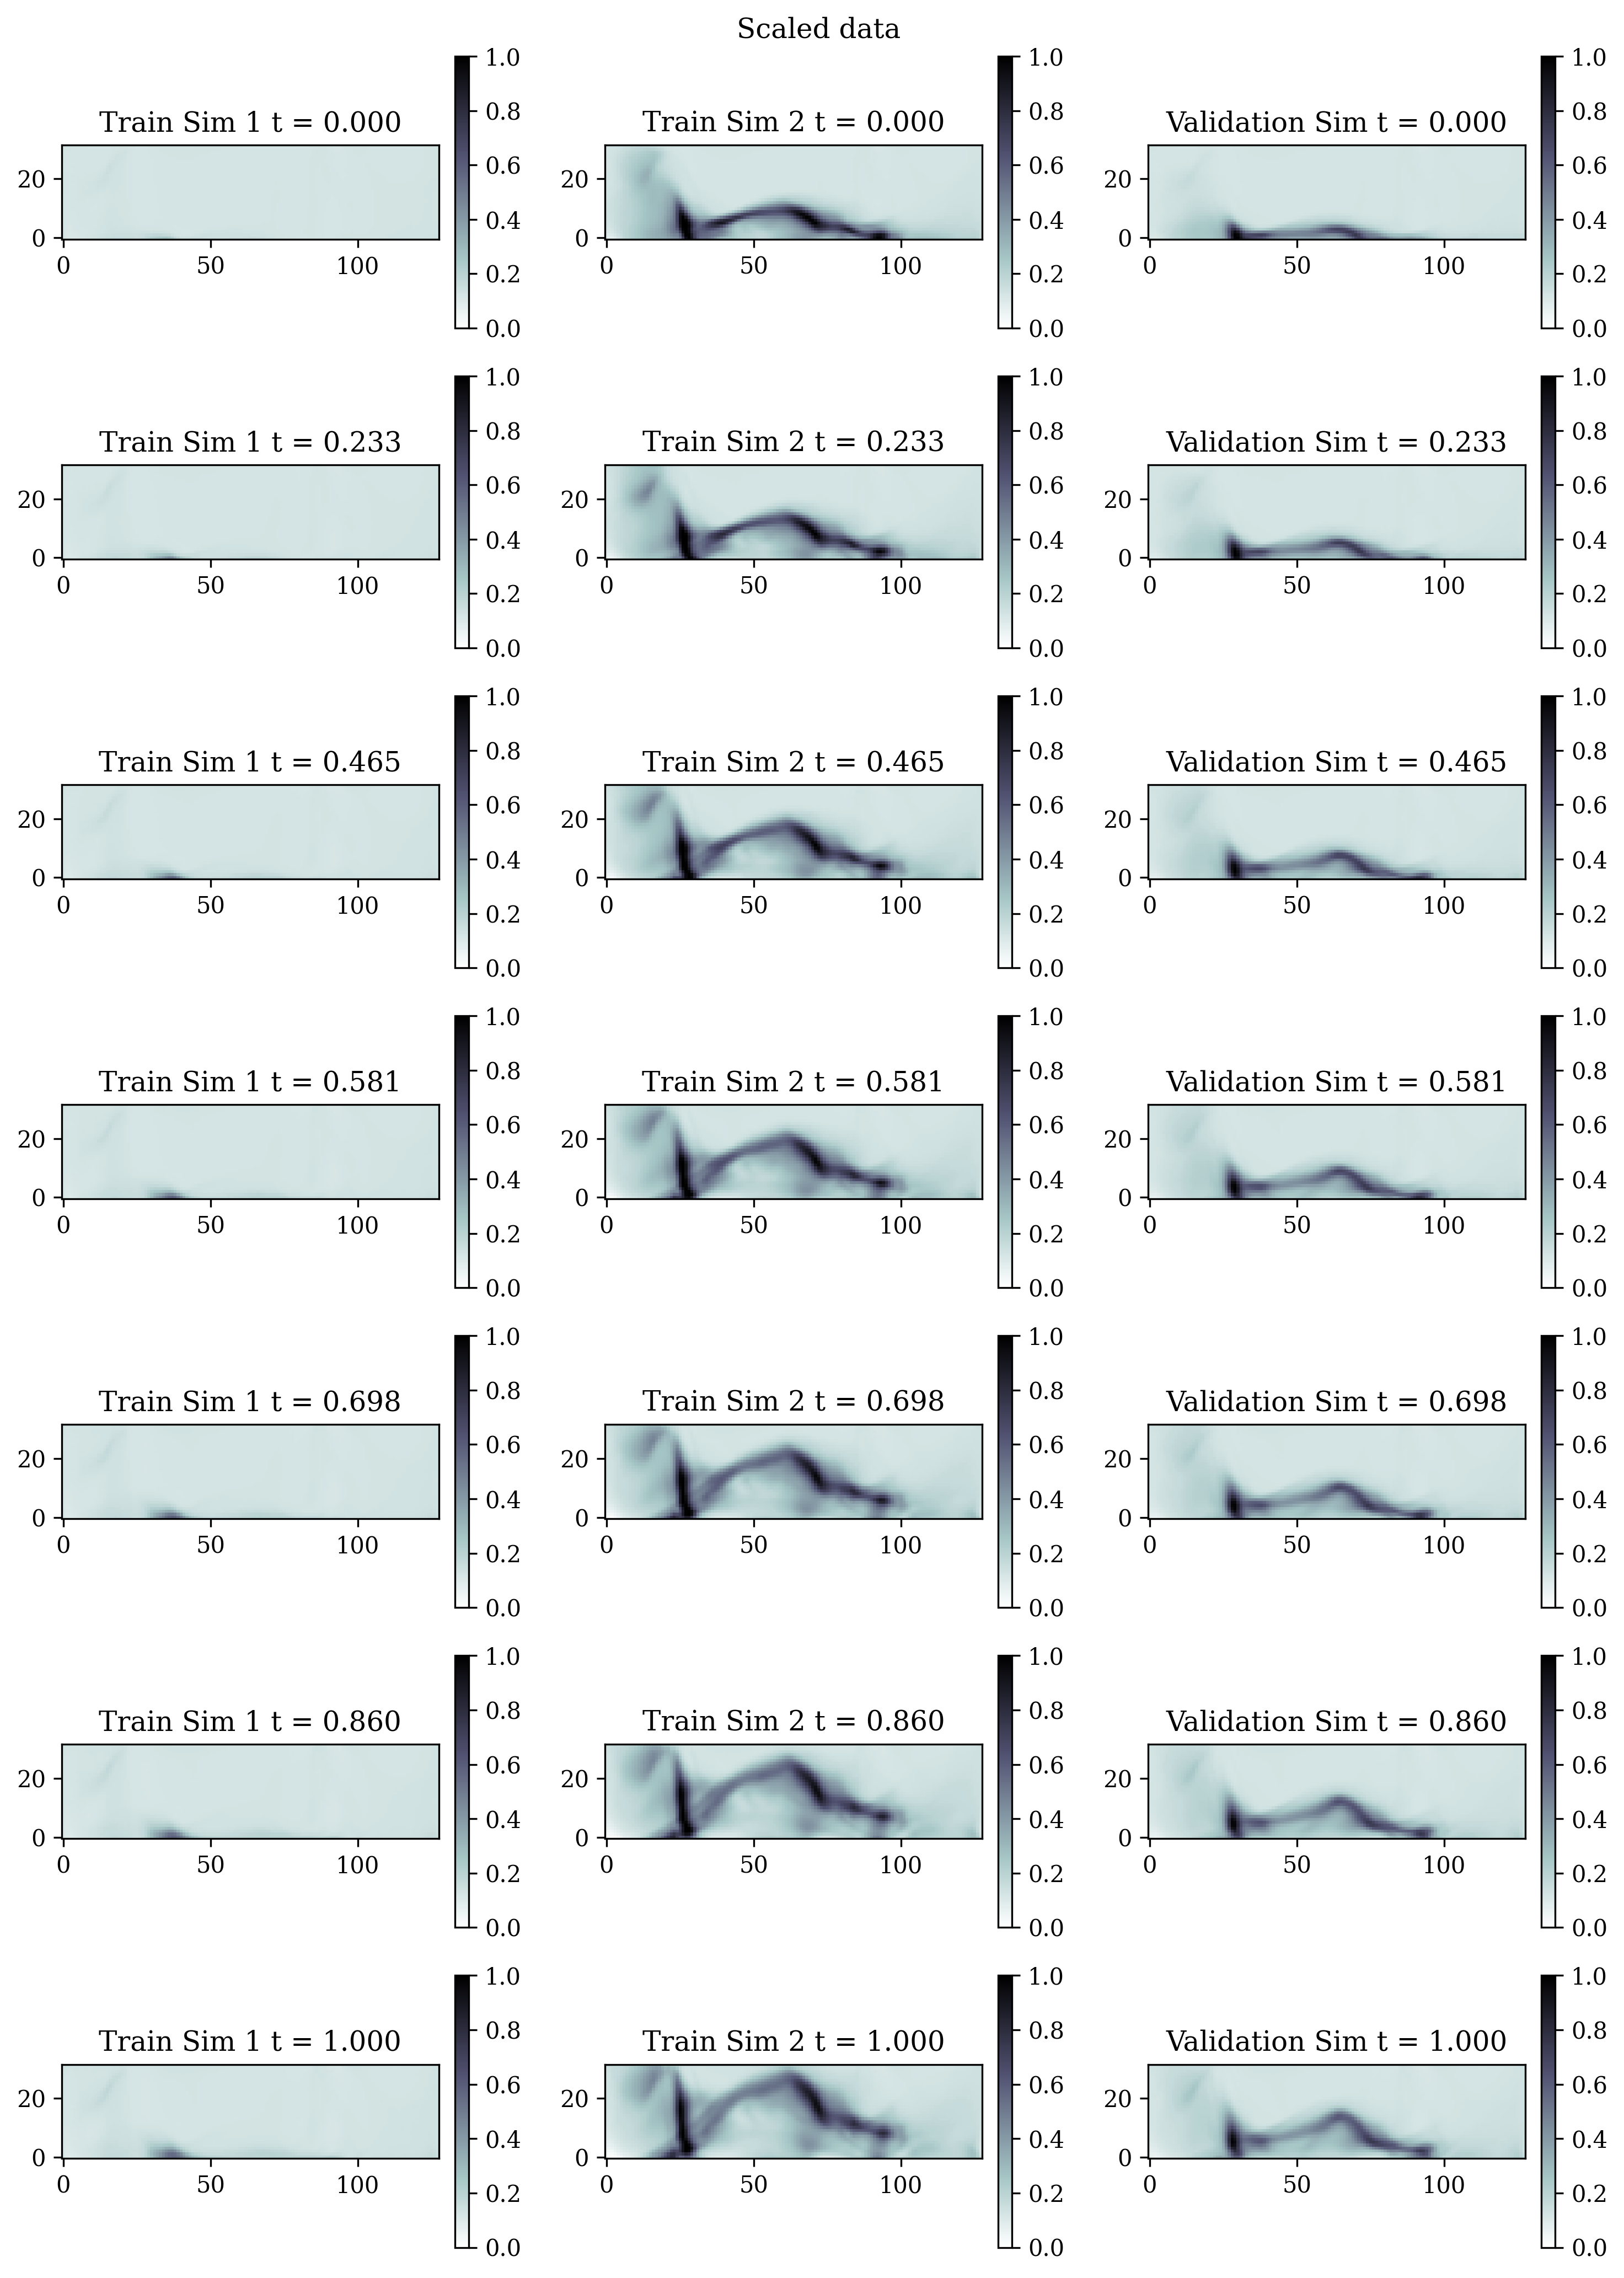

In [57]:
time_idx_to_plot = np.array([0, 10, 20, 25, 30, 37, 43])
qoi_idx = 1

fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(10, 14))

for row in range(7):
    im = axs[row, 0].imshow(train_raw_scaled[0, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=0,
                           vmax=1
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 0])
    axs[row, 0].set_title("Train Sim 1 t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
      

for row in range(7):
    im = axs[row, 1].imshow(train_raw_scaled[1, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                            vmin=0,
                            vmax=1
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 1])
    axs[row, 1].set_title("Train Sim 2 t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
    
    
for row in range(7):
    im = axs[row, 2].imshow(val_raw_scaled[0, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                            vmin=0,
                            vmax=1
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 2])
    axs[row, 2].set_title("Validation Sim t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))

fig.suptitle("Scaled data")
fig.tight_layout()

Scale Params

In [58]:
import copy

train_params_scaled = copy.deepcopy(train_params_raw)
val_params_scaled = copy.deepcopy(val_params_raw)
test_params_scaled = copy.deepcopy(test_params_raw)

train_params_scaled[:, 0] = train_params_raw[:, 0]/50
val_params_scaled[:, 0] = val_params_raw[:, 0]/50
test_params_scaled[:, 0] = test_params_raw[:, 0]/50

train_params_scaled, val_params_scaled, test_params_scaled

(array([[0.134678, 1.      ],
        [0.4144  , 1.      ]]),
 array([[0.259, 1.   ]]),
 array([[0.196838, 1.      ]]))

In [59]:
val_params_scaled.shape

(1, 2)

In [60]:
# repeat param values.
train_params_ts = np.repeat(train_params_scaled.reshape((2, 2, 1)), 44, axis=2)
val_params_ts = np.repeat(val_params_scaled.reshape((1, 2, 1)), 44, axis=2)
test_params_ts = np.repeat(test_params_scaled.reshape((1, 2, 1)), 44, axis=2)

In [61]:
# torch.Tensor(np.transpose(train_params_ts, (0, 2, 1))).shape

In [62]:
train_params_ts[:, :, 1], val_params_ts[:, :, 2], test_params_ts[:, :, 4]

(array([[0.134678, 1.      ],
        [0.4144  , 1.      ]]),
 array([[0.259, 1.   ]]),
 array([[0.196838, 1.      ]]))

Combine data and params - keep same format as 2D QoI PNODE Paper.

In [63]:
train_raw_scaled.shape

torch.Size([2, 44, 32, 128])

In [64]:
train_snaps = train_raw_scaled.reshape(2, 44, -1)
val_snaps = val_raw_scaled.reshape(1, 44, -1)
test_snaps = test_raw_scaled.reshape(1, 44, -1)

train_snaps.shape, val_snaps.shape, test_snaps.shape

(torch.Size([2, 44, 4096]),
 torch.Size([1, 44, 4096]),
 torch.Size([1, 44, 4096]))

In [65]:
train_param_snaps = torch.cat((train_snaps, torch.Tensor(np.transpose(train_params_ts, (0, 2, 1)))), 2)
val_param_snaps = torch.cat((val_snaps, torch.Tensor(np.transpose(val_params_ts, (0, 2, 1)))), 2)
test_param_snaps = torch.cat((test_snaps, torch.Tensor(np.transpose(test_params_ts, (0, 2, 1)))), 2)

In [66]:
train_dataset = []
val_dataset = []
test_dataset = []

for i in range(2):
    train_dataset.append((train_param_snaps[i:(i+1), :, :], tpredict))

for i in range(1):
    val_dataset.append((val_param_snaps[i:(i+1), :, :], tpredict))
    
for i in range(1):
    test_dataset.append((test_param_snaps[i:(i+1), :, :], tpredict))


In [67]:
input_dim = 4096
param_dim = 2

In [68]:
def collate_fn_wl(batch, input_dim, device):
    data = torch.zeros([len(batch), 1, batch[0][0].shape[2]]).to(device)
    target = torch.zeros([len(batch), batch[0][0].shape[1]-1, input_dim]).to(device)
    
    for b, (snap, ts) in enumerate(batch):
        data[b, 0, :] = snap[:, 0, :]
        target[b, :, :] = snap[:, 1:, :input_dim]
        
        data_ts = ts[:1]
        target_ts = ts[1:]
        
    data_dict = {"observed_data": data.permute(1, 0, 2),
                "observed_tp": data_ts,
                "data_to_predict": target,
                "tp_to_predict": target_ts}
    
    return data_dict

In [69]:
def get_next_batch(dataloader, device=torch.device("cuda:0")):
    return dataloader.__next__()

In [70]:
def inf_generator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, (x, y) in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

In [71]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size = len(train_dataset), 
                              shuffle=False, 
                              collate_fn = lambda batch: collate_fn_wl(batch, input_dim, device))


val_dataloader = DataLoader(val_dataset, 
                          batch_size = len(val_dataset), 
                          shuffle=False, 
                          collate_fn = lambda batch: collate_fn_wl(batch, input_dim, device))

test_dataloader = DataLoader(test_dataset, 
                          batch_size = len(test_dataset), 
                          shuffle=False, 
                          collate_fn = lambda batch: collate_fn_wl(batch, input_dim, device))

In [72]:
data_obj = {"train_dataloader": inf_generator(train_dataloader),
           "val_dataloader": inf_generator(val_dataloader),
           "test_dataloader": inf_generator(test_dataloader)}

In [73]:
# bd = get_next_batch(data_obj["train_dataloader"])

In [74]:
# bd["observed_data"].shape, bd["observed_tp"].shape, bd["data_to_predict"].shape, bd["tp_to_predict"].shape

In [75]:
64 * 32

2048

Define Model Architecture, verify dimensions and forward pass syntax for each component!

Original Code had `nn.Conv1d` in the `init_network_weights_xavier_normal` def, fixing that for the 2D case.

In [76]:
def init_network_weights_xavier_normal(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, val=0)

In [77]:
# Define Encoder-Decoder PNODE Now
class ODENet(nn.Module):
    def __init__(self, 
                 latent_dim, 
                 param_dim,
                 n_layers=1,
                 n_units=100,
                 nonlinear=nn.ELU):
    
        super(ODENet, self).__init__()
        layers = [nn.Linear(latent_dim + param_dim, n_units)]
        for i in range(n_layers - 1):
            layers.append(nonlinear())
            layers.append(nn.Linear(n_units, n_units))

        layers.append(nonlinear())
        layers.append(nn.Linear(n_units, latent_dim))  
        odenet = nn.Sequential(*layers)

        init_network_weights_xavier_normal(odenet)

        self.odenet = odenet
        self.latent_dim = latent_dim
    
    def forward(self, t, y):
        
        output = torch.cat((self.odenet(y),
                    torch.zeros_like(y[:, :, self.latent_dim:])), 
                    -1)
        
        return output

class PNODE_Conv(nn.Module):
    def __init__(self, 
                 input_dim,
                 latent_dim,
                 param_dim, 
                 n_layers=1, 
                 n_units=100,
                 nonlinear=nn.ELU):
        super(PNODE_Conv, self).__init__()
        
        encoder = nn.Sequential(nn.ZeroPad2d((7,8,7,8)),
                        nn.Conv2d(1,8,16,stride=(2,2),padding=(0,0)),
                        nn.ELU(),
                        nn.ZeroPad2d((3,4,3,4)),
                        nn.Conv2d(8,16,8,stride=(2,2),padding=(0,0)),
                        nn.ELU(),
                        nn.ZeroPad2d((1,2,1,2)),
                        nn.Conv2d(16,32,4,stride=(2,2),padding=(0,0)),
                        nn.ELU(),
                        nn.ZeroPad2d((1,2,1,2)),
                        nn.Conv2d(32,64,4,stride=(2,2),padding=(0,0)),
                        nn.ELU(),
                        nn.Flatten(),
                        nn.Linear(1024,latent_dim), 
                        nn.ELU()) 
        

        
        decoder_mlp = nn.Sequential(nn.Linear(latent_dim, 512),
                                    nn.ELU())
        
        decoder_conv = nn.Sequential(nn.ConvTranspose2d(64,32,(4,4),stride=(2,2),padding=(1,1)),
                                     nn.ELU(),
                                     nn.ConvTranspose2d(32,16,(4,4),stride=(2,2),padding=(1,1)),
                                     nn.ELU(),
                                     nn.ConvTranspose2d(16,8,(8,8),stride=(2,2),padding=(3,3)),
                                     nn.ELU(),
                                     nn.ConvTranspose2d(8,2,(16,16),stride=(2,2),padding=(7,7)))
        
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        self.encoder=encoder
        self.pnode=ODENet(latent_dim, param_dim).to(device)
        self.decoder_mlp = decoder_mlp
        self.decoder_conv = decoder_conv
        
        
        init_network_weights_xavier_normal(encoder)
        init_network_weights_xavier_normal(decoder_mlp)
        init_network_weights_xavier_normal(decoder_conv)
        
        
    def forward(self, t, y):
        nbatch, ntraj, nseq = y.shape
        y_init = y[:, :, :self.input_dim].reshape((nbatch * ntraj, 1, 32, 128))
        init_latent = self.encoder(y_init).reshape((nbatch, ntraj, self.latent_dim))
        init_latent = torch.cat((init_latent, y[:, :, self.input_dim:]),-1)
        latent_states = odeint(self.pnode, init_latent, t)
        ntraj, nbatch, nseq, _  = latent_states.shape
        latent_mlp = self.decoder_mlp(latent_states[:, :, :, :self.latent_dim])
        decoder_features = latent_mlp.reshape((44, 64, -1, 8))
        pred_sol = self.decoder_conv(decoder_features)
        pred_sol = pred_sol.reshape((ntraj, nseq, 32, 128))
        
        return pred_sol

Training Loop

In [78]:
def update_learning_rate(optimizer, decay_rate = 0.999, lowest = 1e-3):
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        lr = max(lr * decay_rate, lowest)
        param_group['lr'] = lr
        
        
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)
        
def save_checkpoint(state, save, epoch):
    if not os.path.exists(save):
        os.makedirs(save)
    filename = os.path.join(save, 'checkpt-%04d.pth' % epoch)
    torch.save(state, filename)
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_ckpt_model(ckpt_path, model, device):
    if not os.path.exists(ckpt_path):
        raise Exception("Checkpoint " + ckpt_path + " does not exist.")
    # Load checkpoint.
    checkpt = torch.load(ckpt_path)
    ckpt_args = checkpt['args']
    state_dict = checkpt['state_dict']
    model_dict = model.state_dict()

    # 1. filter out unnecessary keys
    state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
    # 2. overwrite entries in the existing state dict
    model_dict.update(state_dict) 
    # 3. load the new state dict
    model.load_state_dict(state_dict)
    model.to(device)

In [79]:
latent_dim = args.latents
latent_dim

8

In [80]:
model = PNODE_Conv(input_dim=4096, latent_dim=args.latents, param_dim=2).to(device)

In [81]:
optimizer = optim.Adamax(model.parameters(), lr=args.lr)

print(args.lr)
pEncoder = count_parameters(model.encoder)
pPNODE = count_parameters(model.pnode)
pDecoder = count_parameters(model.decoder_mlp) + count_parameters(model.decoder_conv)

print(pEncoder + pPNODE + pDecoder)

0.01
119342


In [82]:
def get_logger(logpath, package_files=[], displaying=True, saving=True, debug=False):
    logger = logging.getLogger()
    if debug:
        level = logging.DEBUG
    else:
        level = logging.INFO
    logger.setLevel(level)
    if saving:
        info_file_handler = logging.FileHandler(logpath, mode="a")
        info_file_handler.setLevel(level)
        logger.addHandler(info_file_handler)
    if displaying:
        console_handler = logging.StreamHandler()
        console_handler.setLevel(level)
        logger.addHandler(console_handler)

    return logger


makedirs(os.path.join(os.getcwd(), "logs"))
logdir = os.path.join(os.getcwd(), "logs")

In [83]:
makedirs(args.save)

if args.load is not None:
    experimentID = args.load
    print("Loading experiment")
else:
    experimentID = int(SystemRandom().random()*100000)
    print("Starting new experiment")
print(experimentID)

ckpt_path = os.path.join(args.save, "experiment_" + str(experimentID) + '.ckpt')
print(ckpt_path)

logger = get_logger(logpath=os.path.join(logdir, "expt_normalized_pnode_images.log"))
logger

Starting new experiment
9291
experiments/experiment_9291.ckpt


<RootLogger root (INFO)>

In [84]:
logger.info(os.getcwd())
logger.info(model)
logger.info("Number of parameters: {}".format(pEncoder + pPNODE + pDecoder))
logger.info(vars(args))
logger.info("Train Idx")
logger.info(train_idx)
logger.info("Validation Idx")
logger.info(val_idx)
logger.info("Test Idx")
logger.info(test_idx)
logger.info("Checkpoint Path")
logger.info(ckpt_path)
logger.info("Input Dim: ")
logger.info(input_dim)
logger.info("Param Dim: ")
logger.info(param_dim)
logger.info("Latent Dim: ")
logger.info(latent_dim)
logger.info(device)

/home/ajivani/WLROM_new/WhiteLight
PNODE_Conv(
  (encoder): Sequential(
    (0): ZeroPad2d((7, 8, 7, 8))
    (1): Conv2d(1, 8, kernel_size=(16, 16), stride=(2, 2))
    (2): ELU(alpha=1.0)
    (3): ZeroPad2d((3, 4, 3, 4))
    (4): Conv2d(8, 16, kernel_size=(8, 8), stride=(2, 2))
    (5): ELU(alpha=1.0)
    (6): ZeroPad2d((1, 2, 1, 2))
    (7): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
    (8): ELU(alpha=1.0)
    (9): ZeroPad2d((1, 2, 1, 2))
    (10): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (11): ELU(alpha=1.0)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=1024, out_features=8, bias=True)
    (14): ELU(alpha=1.0)
  )
  (pnode): ODENet(
    (odenet): Sequential(
      (0): Linear(in_features=10, out_features=100, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=100, out_features=8, bias=True)
    )
  )
  (decoder_mlp): Sequential(
    (0): Linear(in_features=8, out_features=512, bias=True)
    (1): ELU(alpha=1.0)
  )
  (dec

In [85]:
train_true_target = torch.permute(train_raw_scaled, (1, 0, 2, 3)).to(device)
val_true_target = torch.permute(val_raw_scaled, (1, 0, 2, 3)).to(device)

train_true_target.shape, val_true_target.shape

# batch_dict = get_next_batch(data_obj["train_dataloader"], device=device)
# val_dict = get_next_batch(data_obj["val_dataloader"], device=device)

# model_pred = model(tpredict.to(device), batch_dict["observed_data"])
# val_pred = model(tpredict.to(device), val_dict["observed_data"])

# model_pred.shape, val_pred.shape

(torch.Size([44, 2, 32, 128]), torch.Size([44, 1, 32, 128]))

In [86]:
best_loss = 1e20
num_batches = 1
n_iters_to_viz = 1
ckpt_freq = 25
if runConv==True:
    for itr in range(1, num_batches * (args.niters + 1)):
        optimizer.zero_grad()
        update_learning_rate(optimizer, 
                           decay_rate = 0.999, 
                           lowest = args.lr / 10)

        batch_dict = get_next_batch(data_obj["train_dataloader"], device=device)
        
        model_pred = model(tpredict.to(device), batch_dict["observed_data"])
        
        loss = torch.mean(torch.abs(train_true_target - model_pred))
        
        loss.backward()
        optimizer.step()

        if itr % (n_iters_to_viz * num_batches) == 0:
            bsave = False
            with torch.no_grad():
                val_dict = get_next_batch(data_obj["val_dataloader"], device=device)
                
                val_pred = model(tpredict.to(device), val_dict["observed_data"])
                test_res = torch.mean(torch.abs(val_true_target - val_pred))

                message = 'Epoch {:04d} [Val seq (cond on sampled tp)] | Loss {:.6e} | Train loss (one batch) {:.6e}]'.format(
                    itr//num_batches, 
                    test_res.item(), loss.item())
                logger.info(message)

                if test_res.item() < best_loss:
                    best_loss = test_res.item()
                    bsave =True

#             if bsave:
            if itr % (ckpt_freq) == 0:
                logger.info("Saving Check Point")
                torch.save({
                    'args': args,
                    'state_dict': model.state_dict(),
                }, ckpt_path)

    if bsave:
        logger.info("Saving Check Point")
        
        torch.save({
            'args': args,
            'state_dict': model.state_dict(),
        }, ckpt_path)

Epoch 0001 [Val seq (cond on sampled tp)] | Loss 8.086751e-02 | Train loss (one batch) 2.184551e-01]
Epoch 0002 [Val seq (cond on sampled tp)] | Loss 2.114553e-01 | Train loss (one batch) 1.015726e-01]
Epoch 0003 [Val seq (cond on sampled tp)] | Loss 1.738872e-01 | Train loss (one batch) 2.127921e-01]
Epoch 0004 [Val seq (cond on sampled tp)] | Loss 1.639255e-01 | Train loss (one batch) 2.039061e-01]
Epoch 0005 [Val seq (cond on sampled tp)] | Loss 1.149754e-01 | Train loss (one batch) 3.163221e-01]
Epoch 0006 [Val seq (cond on sampled tp)] | Loss 2.532769e-01 | Train loss (one batch) 1.740937e-01]
Epoch 0007 [Val seq (cond on sampled tp)] | Loss 1.375505e-01 | Train loss (one batch) 6.168967e-01]
Epoch 0008 [Val seq (cond on sampled tp)] | Loss 1.248778e-01 | Train loss (one batch) 1.335844e-01]
Epoch 0009 [Val seq (cond on sampled tp)] | Loss 1.469299e-01 | Train loss (one batch) 9.191824e-02]
Epoch 0010 [Val seq (cond on sampled tp)] | Loss 1.397956e-01 | Train loss (one batch) 1.76

Epoch 0082 [Val seq (cond on sampled tp)] | Loss 9.278497e-02 | Train loss (one batch) 3.390050e-02]
Epoch 0083 [Val seq (cond on sampled tp)] | Loss 9.287164e-02 | Train loss (one batch) 3.378949e-02]
Epoch 0084 [Val seq (cond on sampled tp)] | Loss 9.278943e-02 | Train loss (one batch) 3.368817e-02]
Epoch 0085 [Val seq (cond on sampled tp)] | Loss 9.251935e-02 | Train loss (one batch) 3.358825e-02]
Epoch 0086 [Val seq (cond on sampled tp)] | Loss 9.224636e-02 | Train loss (one batch) 3.348380e-02]
Epoch 0087 [Val seq (cond on sampled tp)] | Loss 9.213680e-02 | Train loss (one batch) 3.338955e-02]
Epoch 0088 [Val seq (cond on sampled tp)] | Loss 9.213251e-02 | Train loss (one batch) 3.329189e-02]
Epoch 0089 [Val seq (cond on sampled tp)] | Loss 9.206194e-02 | Train loss (one batch) 3.319298e-02]
Epoch 0090 [Val seq (cond on sampled tp)] | Loss 9.186315e-02 | Train loss (one batch) 3.310102e-02]
Epoch 0091 [Val seq (cond on sampled tp)] | Loss 9.166124e-02 | Train loss (one batch) 3.30

Epoch 0163 [Val seq (cond on sampled tp)] | Loss 8.965371e-02 | Train loss (one batch) 2.822945e-02]
Epoch 0164 [Val seq (cond on sampled tp)] | Loss 8.962352e-02 | Train loss (one batch) 2.817575e-02]
Epoch 0165 [Val seq (cond on sampled tp)] | Loss 8.961310e-02 | Train loss (one batch) 2.812212e-02]
Epoch 0166 [Val seq (cond on sampled tp)] | Loss 8.959583e-02 | Train loss (one batch) 2.806858e-02]
Epoch 0167 [Val seq (cond on sampled tp)] | Loss 8.956284e-02 | Train loss (one batch) 2.801516e-02]
Epoch 0168 [Val seq (cond on sampled tp)] | Loss 8.955848e-02 | Train loss (one batch) 2.796185e-02]
Epoch 0169 [Val seq (cond on sampled tp)] | Loss 8.954985e-02 | Train loss (one batch) 2.790853e-02]
Epoch 0170 [Val seq (cond on sampled tp)] | Loss 8.952958e-02 | Train loss (one batch) 2.785531e-02]
Epoch 0171 [Val seq (cond on sampled tp)] | Loss 8.952135e-02 | Train loss (one batch) 2.780217e-02]
Epoch 0172 [Val seq (cond on sampled tp)] | Loss 8.951173e-02 | Train loss (one batch) 2.77

Epoch 0244 [Val seq (cond on sampled tp)] | Loss 8.955503e-02 | Train loss (one batch) 2.446263e-02]
Epoch 0245 [Val seq (cond on sampled tp)] | Loss 8.957142e-02 | Train loss (one batch) 2.442352e-02]
Epoch 0246 [Val seq (cond on sampled tp)] | Loss 8.959343e-02 | Train loss (one batch) 2.438453e-02]
Epoch 0247 [Val seq (cond on sampled tp)] | Loss 8.960585e-02 | Train loss (one batch) 2.434568e-02]
Epoch 0248 [Val seq (cond on sampled tp)] | Loss 8.961727e-02 | Train loss (one batch) 2.430690e-02]
Epoch 0249 [Val seq (cond on sampled tp)] | Loss 8.963603e-02 | Train loss (one batch) 2.426830e-02]
Epoch 0250 [Val seq (cond on sampled tp)] | Loss 8.964042e-02 | Train loss (one batch) 2.422988e-02]
Saving Check Point
Epoch 0251 [Val seq (cond on sampled tp)] | Loss 8.966729e-02 | Train loss (one batch) 2.419162e-02]
Epoch 0252 [Val seq (cond on sampled tp)] | Loss 8.965426e-02 | Train loss (one batch) 2.415360e-02]
Epoch 0253 [Val seq (cond on sampled tp)] | Loss 8.970416e-02 | Train lo

Epoch 0325 [Val seq (cond on sampled tp)] | Loss 9.047465e-02 | Train loss (one batch) 2.176373e-02]
Saving Check Point
Epoch 0326 [Val seq (cond on sampled tp)] | Loss 8.982878e-02 | Train loss (one batch) 2.172564e-02]
Epoch 0327 [Val seq (cond on sampled tp)] | Loss 9.048831e-02 | Train loss (one batch) 2.170456e-02]
Epoch 0328 [Val seq (cond on sampled tp)] | Loss 8.983473e-02 | Train loss (one batch) 2.166751e-02]
Epoch 0329 [Val seq (cond on sampled tp)] | Loss 9.049668e-02 | Train loss (one batch) 2.164475e-02]
Epoch 0330 [Val seq (cond on sampled tp)] | Loss 8.984257e-02 | Train loss (one batch) 2.160531e-02]
Epoch 0331 [Val seq (cond on sampled tp)] | Loss 9.050779e-02 | Train loss (one batch) 2.158311e-02]
Epoch 0332 [Val seq (cond on sampled tp)] | Loss 8.984114e-02 | Train loss (one batch) 2.154546e-02]
Epoch 0333 [Val seq (cond on sampled tp)] | Loss 9.050988e-02 | Train loss (one batch) 2.152369e-02]
Epoch 0334 [Val seq (cond on sampled tp)] | Loss 8.983786e-02 | Train lo

Epoch 0406 [Val seq (cond on sampled tp)] | Loss 9.020140e-02 | Train loss (one batch) 1.962159e-02]
Epoch 0407 [Val seq (cond on sampled tp)] | Loss 9.101116e-02 | Train loss (one batch) 1.961244e-02]
Epoch 0408 [Val seq (cond on sampled tp)] | Loss 9.022912e-02 | Train loss (one batch) 1.957577e-02]
Epoch 0409 [Val seq (cond on sampled tp)] | Loss 9.099998e-02 | Train loss (one batch) 1.955957e-02]
Epoch 0410 [Val seq (cond on sampled tp)] | Loss 9.025339e-02 | Train loss (one batch) 1.952163e-02]
Epoch 0411 [Val seq (cond on sampled tp)] | Loss 9.101459e-02 | Train loss (one batch) 1.950529e-02]
Epoch 0412 [Val seq (cond on sampled tp)] | Loss 9.024005e-02 | Train loss (one batch) 1.947810e-02]
Epoch 0413 [Val seq (cond on sampled tp)] | Loss 9.105112e-02 | Train loss (one batch) 1.947230e-02]
Epoch 0414 [Val seq (cond on sampled tp)] | Loss 9.024877e-02 | Train loss (one batch) 1.944337e-02]
Epoch 0415 [Val seq (cond on sampled tp)] | Loss 9.104551e-02 | Train loss (one batch) 1.94

Epoch 0487 [Val seq (cond on sampled tp)] | Loss 9.144875e-02 | Train loss (one batch) 1.807554e-02]
Epoch 0488 [Val seq (cond on sampled tp)] | Loss 9.065006e-02 | Train loss (one batch) 1.805106e-02]
Epoch 0489 [Val seq (cond on sampled tp)] | Loss 9.145295e-02 | Train loss (one batch) 1.804332e-02]
Epoch 0490 [Val seq (cond on sampled tp)] | Loss 9.065048e-02 | Train loss (one batch) 1.801797e-02]
Epoch 0491 [Val seq (cond on sampled tp)] | Loss 9.148282e-02 | Train loss (one batch) 1.801147e-02]
Epoch 0492 [Val seq (cond on sampled tp)] | Loss 9.064282e-02 | Train loss (one batch) 1.798531e-02]
Epoch 0493 [Val seq (cond on sampled tp)] | Loss 9.147967e-02 | Train loss (one batch) 1.797205e-02]
Epoch 0494 [Val seq (cond on sampled tp)] | Loss 9.066554e-02 | Train loss (one batch) 1.794014e-02]
Epoch 0495 [Val seq (cond on sampled tp)] | Loss 9.149345e-02 | Train loss (one batch) 1.792550e-02]
Epoch 0496 [Val seq (cond on sampled tp)] | Loss 9.064933e-02 | Train loss (one batch) 1.79

Epoch 0568 [Val seq (cond on sampled tp)] | Loss 9.059592e-02 | Train loss (one batch) 1.682836e-02]
Epoch 0569 [Val seq (cond on sampled tp)] | Loss 9.132770e-02 | Train loss (one batch) 1.683479e-02]
Epoch 0570 [Val seq (cond on sampled tp)] | Loss 9.063121e-02 | Train loss (one batch) 1.680258e-02]
Epoch 0571 [Val seq (cond on sampled tp)] | Loss 9.128523e-02 | Train loss (one batch) 1.676699e-02]
Epoch 0572 [Val seq (cond on sampled tp)] | Loss 9.061676e-02 | Train loss (one batch) 1.672974e-02]
Epoch 0573 [Val seq (cond on sampled tp)] | Loss 9.135832e-02 | Train loss (one batch) 1.672170e-02]
Epoch 0574 [Val seq (cond on sampled tp)] | Loss 9.052109e-02 | Train loss (one batch) 1.670958e-02]
Epoch 0575 [Val seq (cond on sampled tp)] | Loss 9.135582e-02 | Train loss (one batch) 1.670634e-02]
Saving Check Point
Epoch 0576 [Val seq (cond on sampled tp)] | Loss 9.055952e-02 | Train loss (one batch) 1.667793e-02]
Epoch 0577 [Val seq (cond on sampled tp)] | Loss 9.127800e-02 | Train lo

Epoch 0649 [Val seq (cond on sampled tp)] | Loss 9.083325e-02 | Train loss (one batch) 1.548226e-02]
Epoch 0650 [Val seq (cond on sampled tp)] | Loss 9.021703e-02 | Train loss (one batch) 1.547087e-02]
Saving Check Point
Epoch 0651 [Val seq (cond on sampled tp)] | Loss 9.087487e-02 | Train loss (one batch) 1.545473e-02]
Epoch 0652 [Val seq (cond on sampled tp)] | Loss 9.020852e-02 | Train loss (one batch) 1.544737e-02]
Epoch 0653 [Val seq (cond on sampled tp)] | Loss 9.084890e-02 | Train loss (one batch) 1.543151e-02]
Epoch 0654 [Val seq (cond on sampled tp)] | Loss 9.025257e-02 | Train loss (one batch) 1.542014e-02]
Epoch 0655 [Val seq (cond on sampled tp)] | Loss 9.078538e-02 | Train loss (one batch) 1.539846e-02]
Epoch 0656 [Val seq (cond on sampled tp)] | Loss 9.029034e-02 | Train loss (one batch) 1.538997e-02]
Epoch 0657 [Val seq (cond on sampled tp)] | Loss 9.077922e-02 | Train loss (one batch) 1.538207e-02]
Epoch 0658 [Val seq (cond on sampled tp)] | Loss 9.026009e-02 | Train lo

Epoch 0730 [Val seq (cond on sampled tp)] | Loss 9.050546e-02 | Train loss (one batch) 1.423853e-02]
Epoch 0731 [Val seq (cond on sampled tp)] | Loss 9.101512e-02 | Train loss (one batch) 1.423002e-02]
Epoch 0732 [Val seq (cond on sampled tp)] | Loss 9.046819e-02 | Train loss (one batch) 1.422842e-02]
Epoch 0733 [Val seq (cond on sampled tp)] | Loss 9.104695e-02 | Train loss (one batch) 1.424630e-02]
Epoch 0734 [Val seq (cond on sampled tp)] | Loss 9.053206e-02 | Train loss (one batch) 1.423335e-02]
Epoch 0735 [Val seq (cond on sampled tp)] | Loss 9.094117e-02 | Train loss (one batch) 1.422848e-02]
Epoch 0736 [Val seq (cond on sampled tp)] | Loss 9.062626e-02 | Train loss (one batch) 1.421418e-02]
Epoch 0737 [Val seq (cond on sampled tp)] | Loss 9.096376e-02 | Train loss (one batch) 1.421664e-02]
Epoch 0738 [Val seq (cond on sampled tp)] | Loss 9.057257e-02 | Train loss (one batch) 1.420321e-02]
Epoch 0739 [Val seq (cond on sampled tp)] | Loss 9.105866e-02 | Train loss (one batch) 1.41

Epoch 0811 [Val seq (cond on sampled tp)] | Loss 9.153172e-02 | Train loss (one batch) 1.336004e-02]
Epoch 0812 [Val seq (cond on sampled tp)] | Loss 9.114777e-02 | Train loss (one batch) 1.333436e-02]
Epoch 0813 [Val seq (cond on sampled tp)] | Loss 9.152769e-02 | Train loss (one batch) 1.331950e-02]
Epoch 0814 [Val seq (cond on sampled tp)] | Loss 9.117164e-02 | Train loss (one batch) 1.329874e-02]
Epoch 0815 [Val seq (cond on sampled tp)] | Loss 9.154383e-02 | Train loss (one batch) 1.329154e-02]
Epoch 0816 [Val seq (cond on sampled tp)] | Loss 9.115881e-02 | Train loss (one batch) 1.328264e-02]
Epoch 0817 [Val seq (cond on sampled tp)] | Loss 9.158251e-02 | Train loss (one batch) 1.328910e-02]
Epoch 0818 [Val seq (cond on sampled tp)] | Loss 9.116882e-02 | Train loss (one batch) 1.328649e-02]
Epoch 0819 [Val seq (cond on sampled tp)] | Loss 9.156898e-02 | Train loss (one batch) 1.328896e-02]
Epoch 0820 [Val seq (cond on sampled tp)] | Loss 9.123299e-02 | Train loss (one batch) 1.32

Epoch 0892 [Val seq (cond on sampled tp)] | Loss 9.153547e-02 | Train loss (one batch) 1.269451e-02]
Epoch 0893 [Val seq (cond on sampled tp)] | Loss 9.186482e-02 | Train loss (one batch) 1.267282e-02]
Epoch 0894 [Val seq (cond on sampled tp)] | Loss 9.155878e-02 | Train loss (one batch) 1.264542e-02]
Epoch 0895 [Val seq (cond on sampled tp)] | Loss 9.186551e-02 | Train loss (one batch) 1.263560e-02]
Epoch 0896 [Val seq (cond on sampled tp)] | Loss 9.155963e-02 | Train loss (one batch) 1.262430e-02]
Epoch 0897 [Val seq (cond on sampled tp)] | Loss 9.188986e-02 | Train loss (one batch) 1.262845e-02]
Epoch 0898 [Val seq (cond on sampled tp)] | Loss 9.155611e-02 | Train loss (one batch) 1.263176e-02]
Epoch 0899 [Val seq (cond on sampled tp)] | Loss 9.190206e-02 | Train loss (one batch) 1.264729e-02]
Epoch 0900 [Val seq (cond on sampled tp)] | Loss 9.160274e-02 | Train loss (one batch) 1.264335e-02]
Saving Check Point
Epoch 0901 [Val seq (cond on sampled tp)] | Loss 9.186450e-02 | Train lo

Epoch 0973 [Val seq (cond on sampled tp)] | Loss 9.195206e-02 | Train loss (one batch) 1.216829e-02]
Epoch 0974 [Val seq (cond on sampled tp)] | Loss 9.180775e-02 | Train loss (one batch) 1.215726e-02]
Epoch 0975 [Val seq (cond on sampled tp)] | Loss 9.199745e-02 | Train loss (one batch) 1.212240e-02]
Saving Check Point
Epoch 0976 [Val seq (cond on sampled tp)] | Loss 9.168596e-02 | Train loss (one batch) 1.207616e-02]
Epoch 0977 [Val seq (cond on sampled tp)] | Loss 9.209510e-02 | Train loss (one batch) 1.205831e-02]
Epoch 0978 [Val seq (cond on sampled tp)] | Loss 9.162816e-02 | Train loss (one batch) 1.205006e-02]
Epoch 0979 [Val seq (cond on sampled tp)] | Loss 9.209975e-02 | Train loss (one batch) 1.205359e-02]
Epoch 0980 [Val seq (cond on sampled tp)] | Loss 9.168577e-02 | Train loss (one batch) 1.204296e-02]
Epoch 0981 [Val seq (cond on sampled tp)] | Loss 9.198453e-02 | Train loss (one batch) 1.203855e-02]
Epoch 0982 [Val seq (cond on sampled tp)] | Loss 9.179620e-02 | Train lo

Let's make a plot of the validation data.

In [87]:
# get model prediction and rescale
batch_dict = get_next_batch(data_obj["train_dataloader"], device=device)
val_dict = get_next_batch(data_obj["val_dataloader"], device=device)

# rescale ground truth.
with torch.no_grad():
    model_pred = model(tpredict.to(device), batch_dict["observed_data"]).cpu().numpy()
    val_pred = model(tpredict.to(device), val_dict["observed_data"]).cpu().numpy()

model_pred_rs = model_pred * (trainMax.item() - trainMin.item()) + trainMin.item()
val_pred_rs = val_pred * (trainMax.item() - trainMin.item()) + trainMin.item()

train_true_rs = train_true_target.cpu().numpy() * (trainMax.item() - trainMin.item()) + trainMin.item()
val_true_rs = val_true_target.cpu().numpy() * (trainMax.item() - trainMin.item()) + trainMin.item()

In [88]:
val_pred_rs.shape

(44, 1, 32, 128)

In [89]:
model_pred_rs.shape

(44, 2, 32, 128)

In [90]:
print(model_pred_rs.min(), model_pred_rs.max())
print(train_true_rs.min(), train_true_rs.max())

0.89870006 1.5190024
0.9297992 1.5000001


In [91]:
print(val_pred_rs.min(), val_pred_rs.max())
print(val_true_rs.min(), val_true_rs.max())

0.9323571 1.2310426
0.9580244 1.4975004


In [92]:
val_abs_err = np.abs(val_true_rs - val_pred_rs)
val_abs_err.min(), val_abs_err.max()

(0.0, 0.49208236)

In [93]:
train_abs_err = np.abs(train_true_rs - model_pred_rs)
train_abs_err.min(), train_abs_err.max()

(0.0, 0.23143196)

Terminology for val sim is wrong, ideally it should just be called the "interpolatory" test sim

In [94]:
tpredict

tensor([0.0000, 0.0233, 0.0465, 0.0698, 0.0930, 0.1163, 0.1395, 0.1628, 0.1860,
        0.2093, 0.2326, 0.2558, 0.2791, 0.3023, 0.3256, 0.3488, 0.3721, 0.3953,
        0.4186, 0.4419, 0.4651, 0.4884, 0.5116, 0.5349, 0.5581, 0.5814, 0.6047,
        0.6279, 0.6512, 0.6744, 0.6977, 0.7209, 0.7442, 0.7674, 0.7907, 0.8140,
        0.8372, 0.8605, 0.8837, 0.9070, 0.9302, 0.9535, 0.9767, 1.0000],
       device='cuda:0')

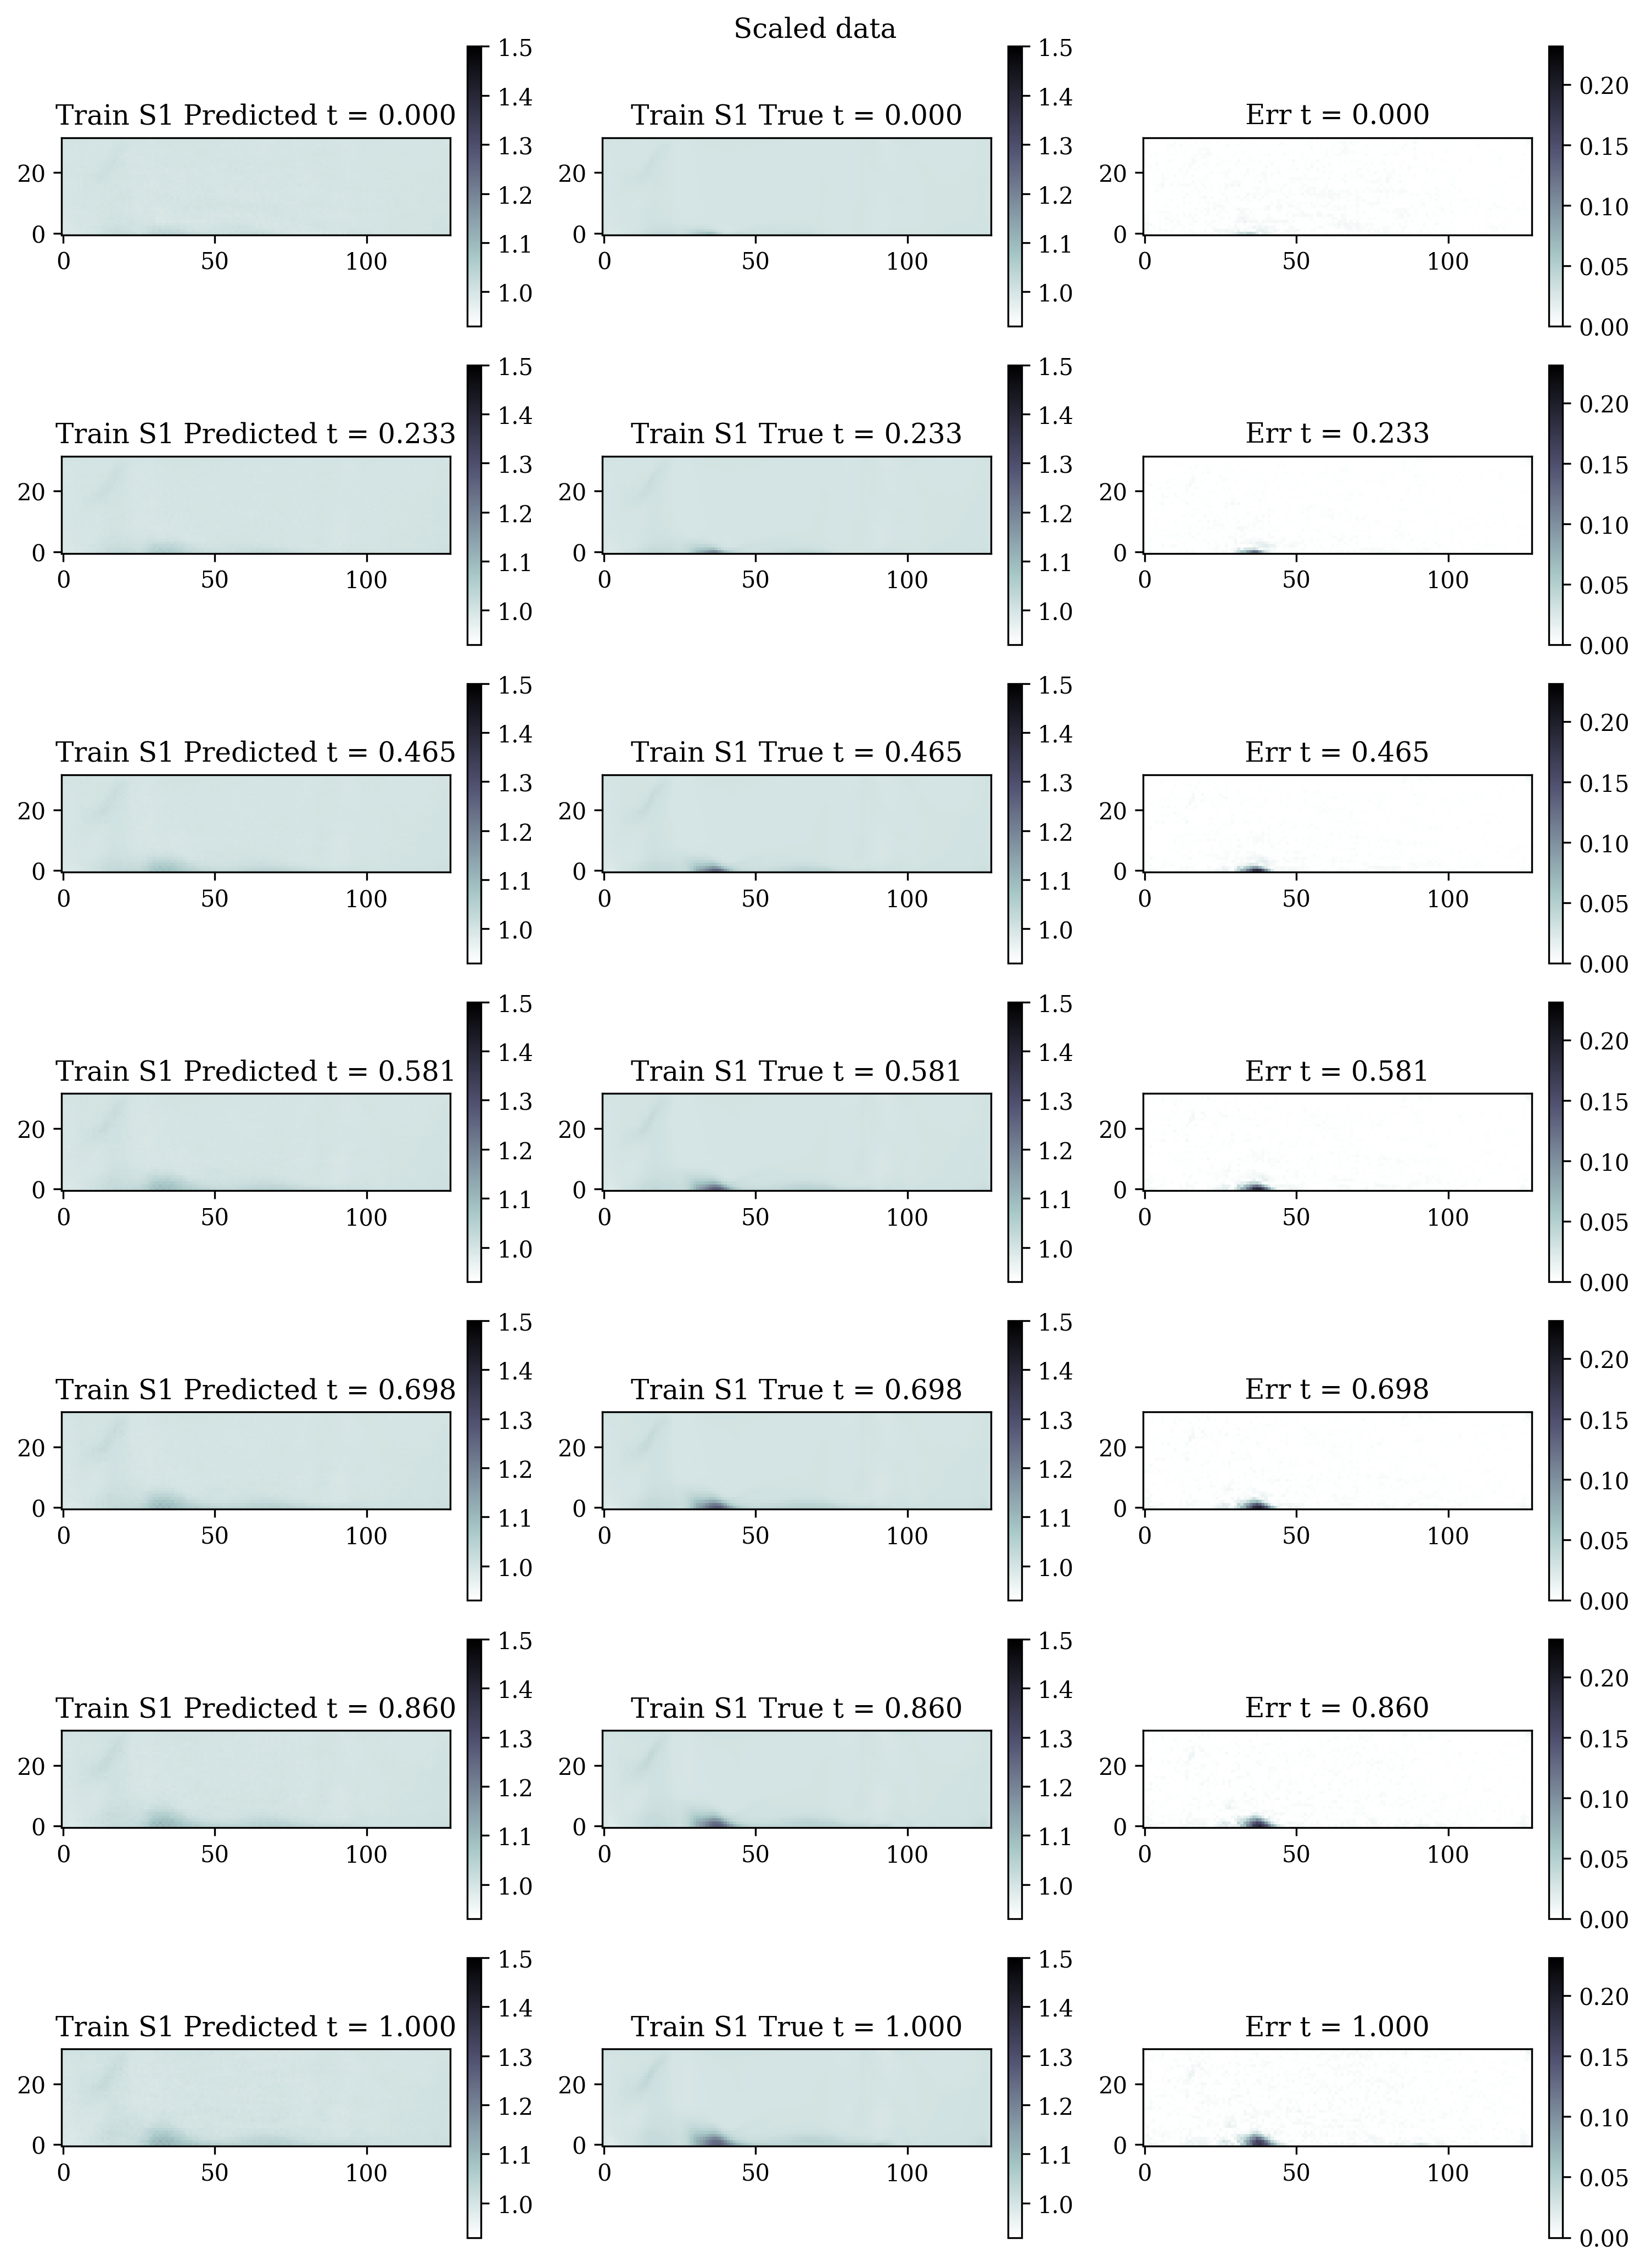

In [95]:
time_idx_to_plot = np.array([0, 10, 20, 25, 30, 37, 43])

fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(10, 14))

for row in range(7):
    im = axs[row, 0].imshow(model_pred_rs[time_idx_to_plot[row], 0, :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=train_true_rs.min(),
                           vmax=train_true_rs.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 0])
    axs[row, 0].set_title("Train S1 Predicted t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
      

for row in range(7):
    im = axs[row, 1].imshow(train_true_rs[time_idx_to_plot[row], 0, :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=train_true_rs.min(),
                           vmax=train_true_rs.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 1])
    axs[row, 1].set_title("Train S1 True t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
    
    
for row in range(7):
    im = axs[row, 2].imshow(train_abs_err[time_idx_to_plot[row], 0, :, :],
                           origin="lower",
                           cmap=lc3,
                            vmin=train_abs_err.min(),
                            vmax=train_abs_err.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 2])
    axs[row, 2].set_title("Err t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))

fig.suptitle("Scaled data")
fig.tight_layout()

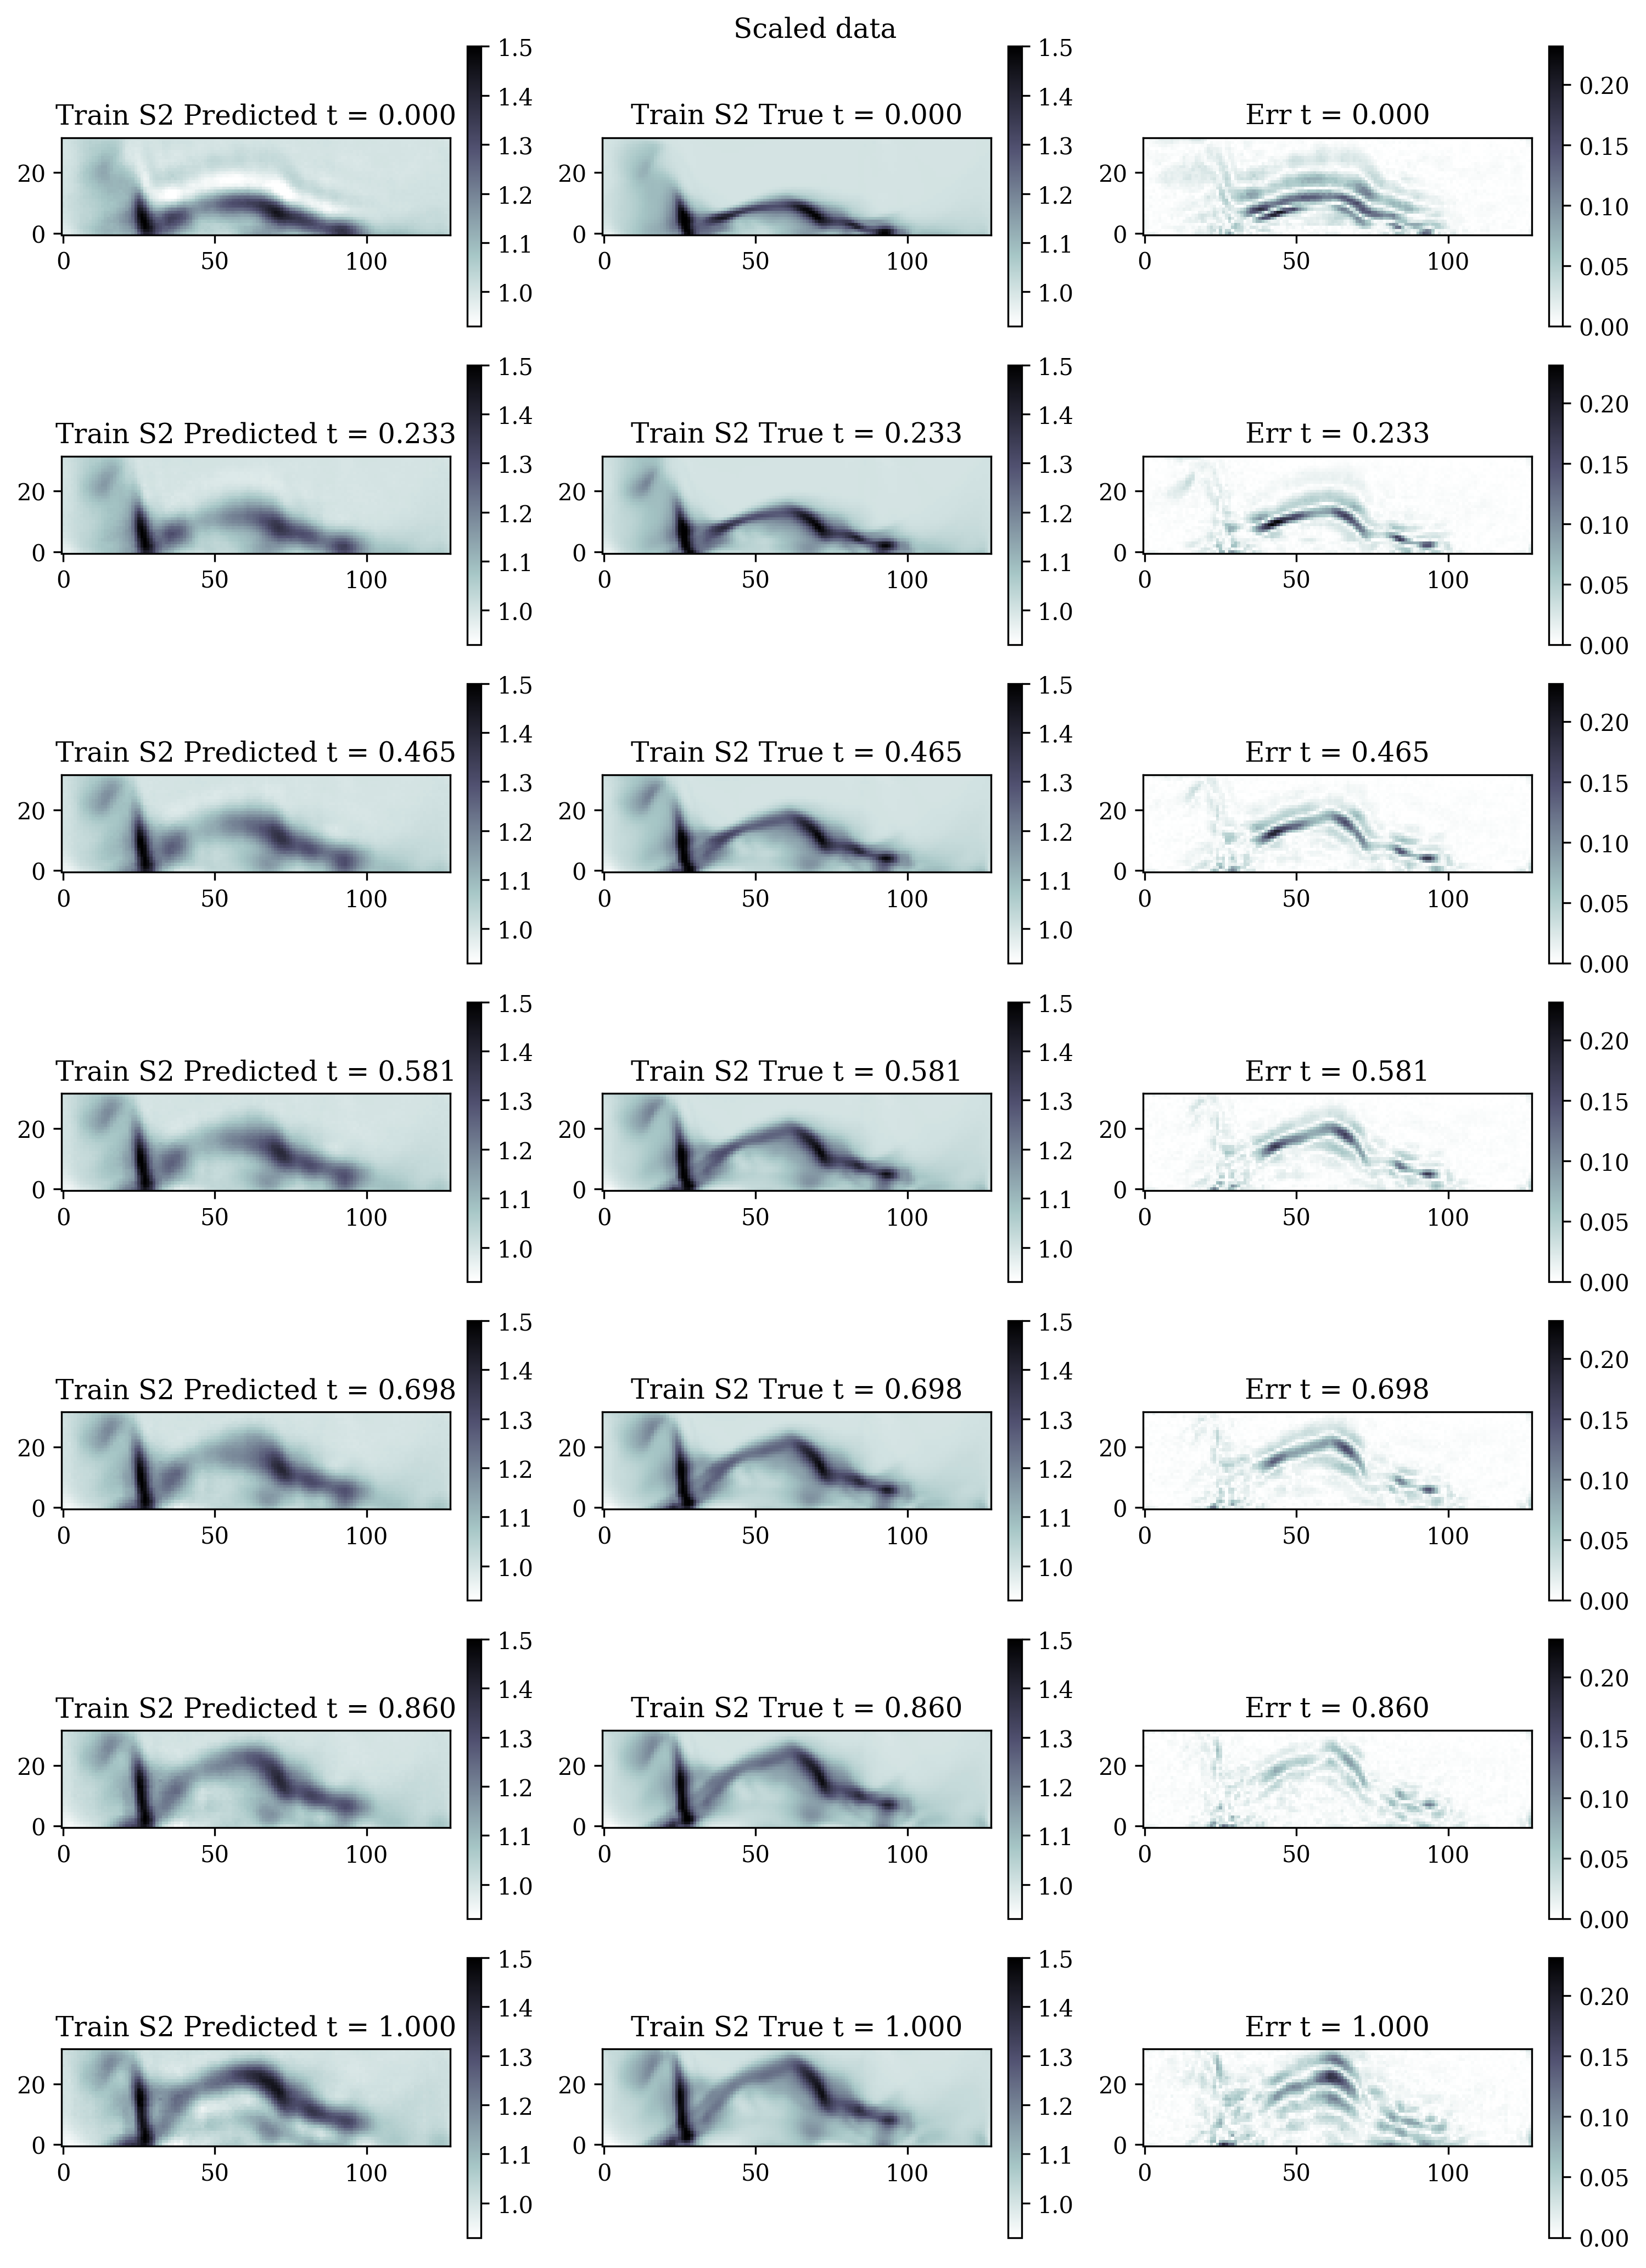

In [96]:
time_idx_to_plot = np.array([0, 10, 20, 25, 30, 37, 43])

fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(10, 14))

for row in range(7):
    im = axs[row, 0].imshow(model_pred_rs[time_idx_to_plot[row], 1, :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=train_true_rs.min(),
                           vmax=train_true_rs.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 0])
    axs[row, 0].set_title("Train S2 Predicted t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
      

for row in range(7):
    im = axs[row, 1].imshow(train_true_rs[time_idx_to_plot[row], 1, :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=train_true_rs.min(),
                           vmax=train_true_rs.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 1])
    axs[row, 1].set_title("Train S2 True t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
    
    
for row in range(7):
    im = axs[row, 2].imshow(train_abs_err[time_idx_to_plot[row], 1, :, :],
                           origin="lower",
                           cmap=lc3,
                            vmin=train_abs_err.min(),
                            vmax=train_abs_err.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 2])
    axs[row, 2].set_title("Err t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))

fig.suptitle("Scaled data")
fig.tight_layout()

In [98]:
val_pred_rs.shape

(44, 1, 32, 128)

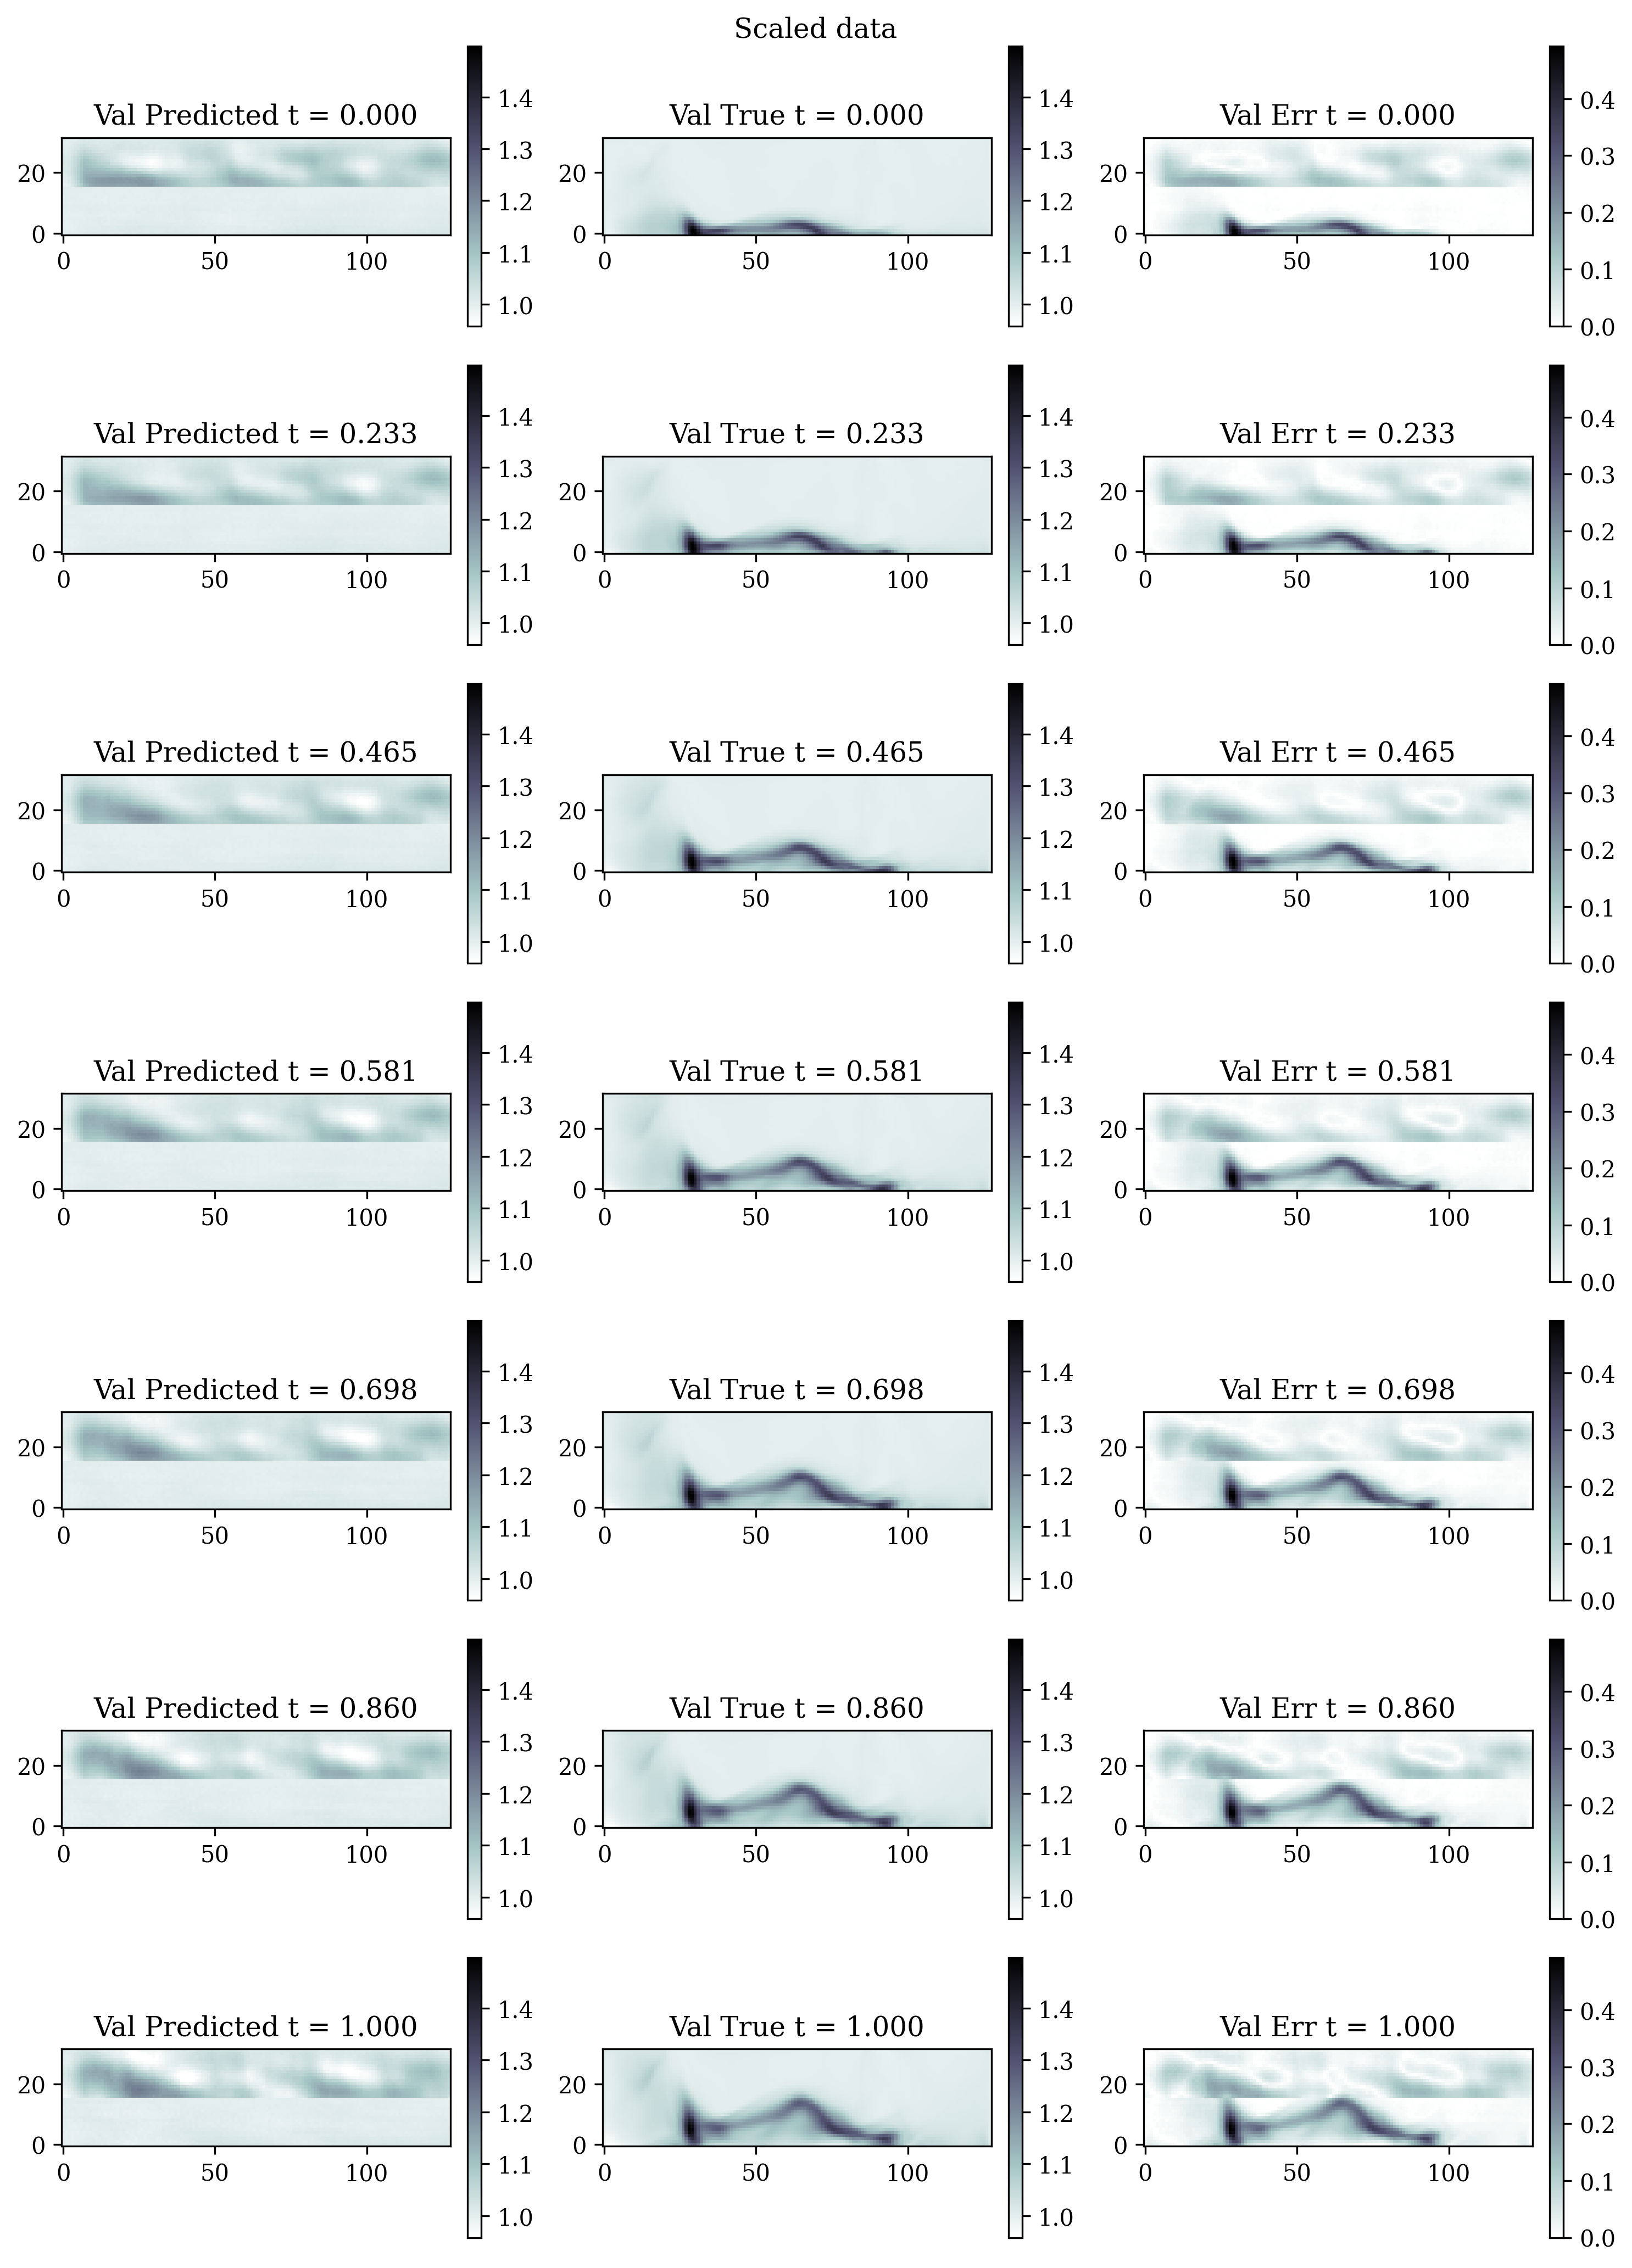

In [157]:
time_idx_to_plot = np.array([0, 10, 20, 25, 30, 37, 43])

fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(10, 14))

for row in range(7):
    im = axs[row, 0].imshow(val_pred_rs[time_idx_to_plot[row], 0, :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=val_true_rs.min(),
                           vmax=val_true_rs.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 0])
    axs[row, 0].set_title("Val Predicted t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
      

for row in range(7):
    im = axs[row, 1].imshow(val_true_rs[time_idx_to_plot[row], 0, :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=val_true_rs.min(),
                           vmax=val_true_rs.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 1])
    axs[row, 1].set_title("Val True t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
    
    
for row in range(7):
    im = axs[row, 2].imshow(val_abs_err[time_idx_to_plot[row], 0, :, :],
                           origin="lower",
                           cmap=lc3,
                            vmin=val_abs_err.min(),
                            vmax=val_abs_err.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 2])
    axs[row, 2].set_title("Val Err t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))

fig.suptitle("Scaled data")
fig.tight_layout()

Results

Try concatenating the initial condition to itself for validation.

In [174]:
val_dict_ct = torch.cat((val_dict["observed_data"], val_dict["observed_data"]), 1)
val_dict_ct.shape

torch.Size([1, 2, 4098])

In [177]:
with torch.no_grad():
    val_pred_ct = model(tpredict.to(device), val_dict_ct).cpu().numpy()
    
val_pred_ct.shape

val_pred_rs_ct = val_pred_ct * (trainMax.item() - trainMin.item()) + trainMin.item()
val_pred_rs_ct.shape

(44, 2, 32, 128)

In [180]:
val_true_target_ct = torch.cat((val_true_target, val_true_target), 1)
print(val_true_target_ct.shape)

val_true_rs_ct = val_true_target_ct.cpu().numpy() * (trainMax.item() - trainMin.item()) + trainMin.item()
print(val_true_rs_ct.shape)

torch.Size([44, 2, 32, 128])
(44, 2, 32, 128)


In [181]:
val_abs_err_ct = np.abs(val_true_rs_ct - val_pred_rs_ct)
val_abs_err_ct.min(), val_abs_err_ct.max()

(0.0, 0.47931743)

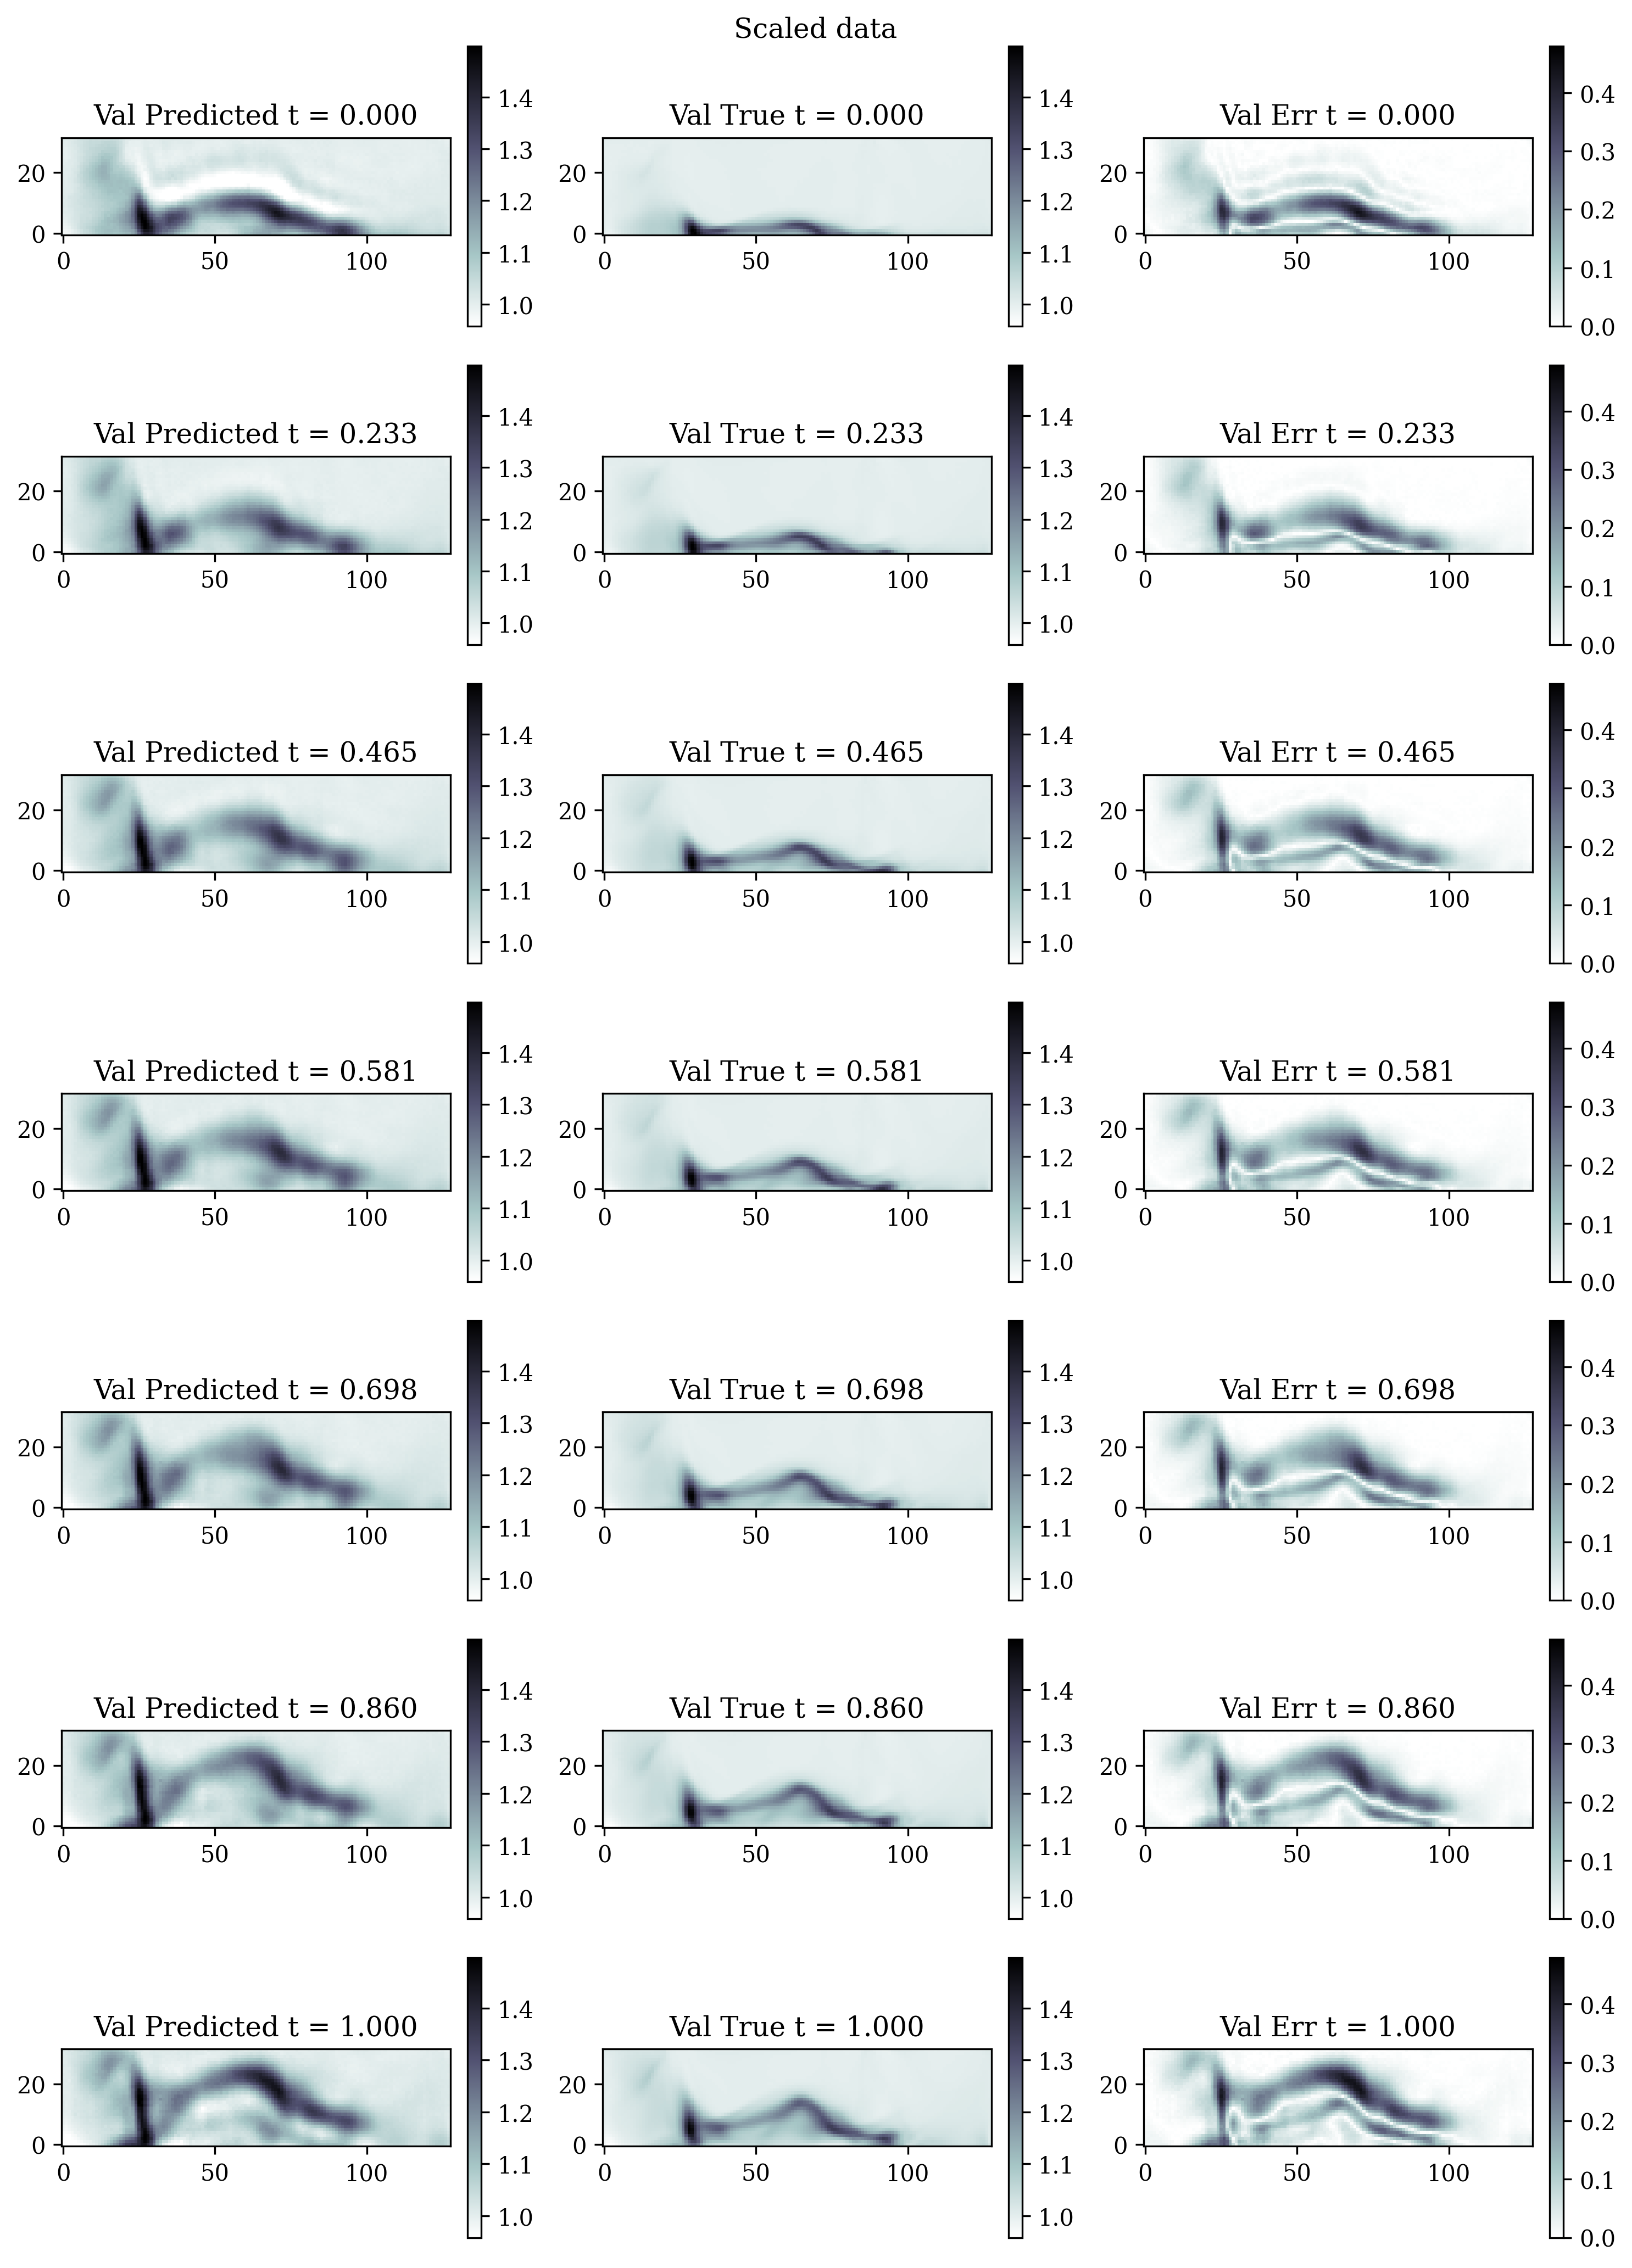

In [183]:
time_idx_to_plot = np.array([0, 10, 20, 25, 30, 37, 43])

fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(10, 14))

for row in range(7):
    im = axs[row, 0].imshow(val_pred_rs_ct[time_idx_to_plot[row], 1, :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=val_true_rs_ct.min(),
                           vmax=val_true_rs_ct.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 0])
    axs[row, 0].set_title("Val Predicted t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
      

for row in range(7):
    im = axs[row, 1].imshow(val_true_rs_ct[time_idx_to_plot[row], 1, :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=val_true_rs_ct.min(),
                           vmax=val_true_rs_ct.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 1])
    axs[row, 1].set_title("Val True t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
    
    
for row in range(7):
    im = axs[row, 2].imshow(val_abs_err_ct[time_idx_to_plot[row], 1, :, :],
                           origin="lower",
                           cmap=lc3,
                            vmin=val_abs_err_ct.min(),
                            vmax=val_abs_err_ct.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 2])
    axs[row, 2].set_title("Val Err t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))

fig.suptitle("Scaled data")
fig.tight_layout()

In [173]:
batch_dict["observed_data"].shape

torch.Size([1, 2, 4098])

In [1]:
# plot train reproduction, val result, test result

### Scratch

Helps in debugging for dimensions of model architecture layers.

In [134]:
# bd = get_next_batch(data_obj["train_dataloader"])
bd = get_next_batch(data_obj["val_dataloader"])
bd["observed_data"].shape, bd["observed_tp"].shape, bd["data_to_predict"].shape, bd["tp_to_predict"].shape

(torch.Size([1, 1, 4098]),
 torch.Size([1]),
 torch.Size([1, 43, 4096]),
 torch.Size([43]))

Though we follow their syntax here, we will use all the timesteps when solution is being passed to `odeint`.

In [135]:
init_state = bd["observed_data"][:, :, :4096]
tp_predict = bd["tp_to_predict"]

In [136]:
latent_dim = 8

In [137]:
model2 = PNODE_Conv(4096, latent_dim, param_dim).to(device)

In [158]:
with torch.no_grad():
    model_pred = model(tpredict.to(device), bd["observed_data"])

In [159]:
model_pred.shape

torch.Size([44, 1, 32, 128])

In [160]:
model_pred1 = model_pred[22, 0, :, :]

In [161]:
model_pred2 = model_pred1.T.reshape((32, 128))
model_pred2.shape

torch.Size([32, 128])

In [148]:
# model_pred3 = model_pred1.reshape((32, 128))
# model_pred3.shape

In [147]:
# model_pred1 == model_pred3

In [ ]:
plt.imshow(model_pred1.cpu().numpy(),
          origin="lower",
          cmap=lc3)

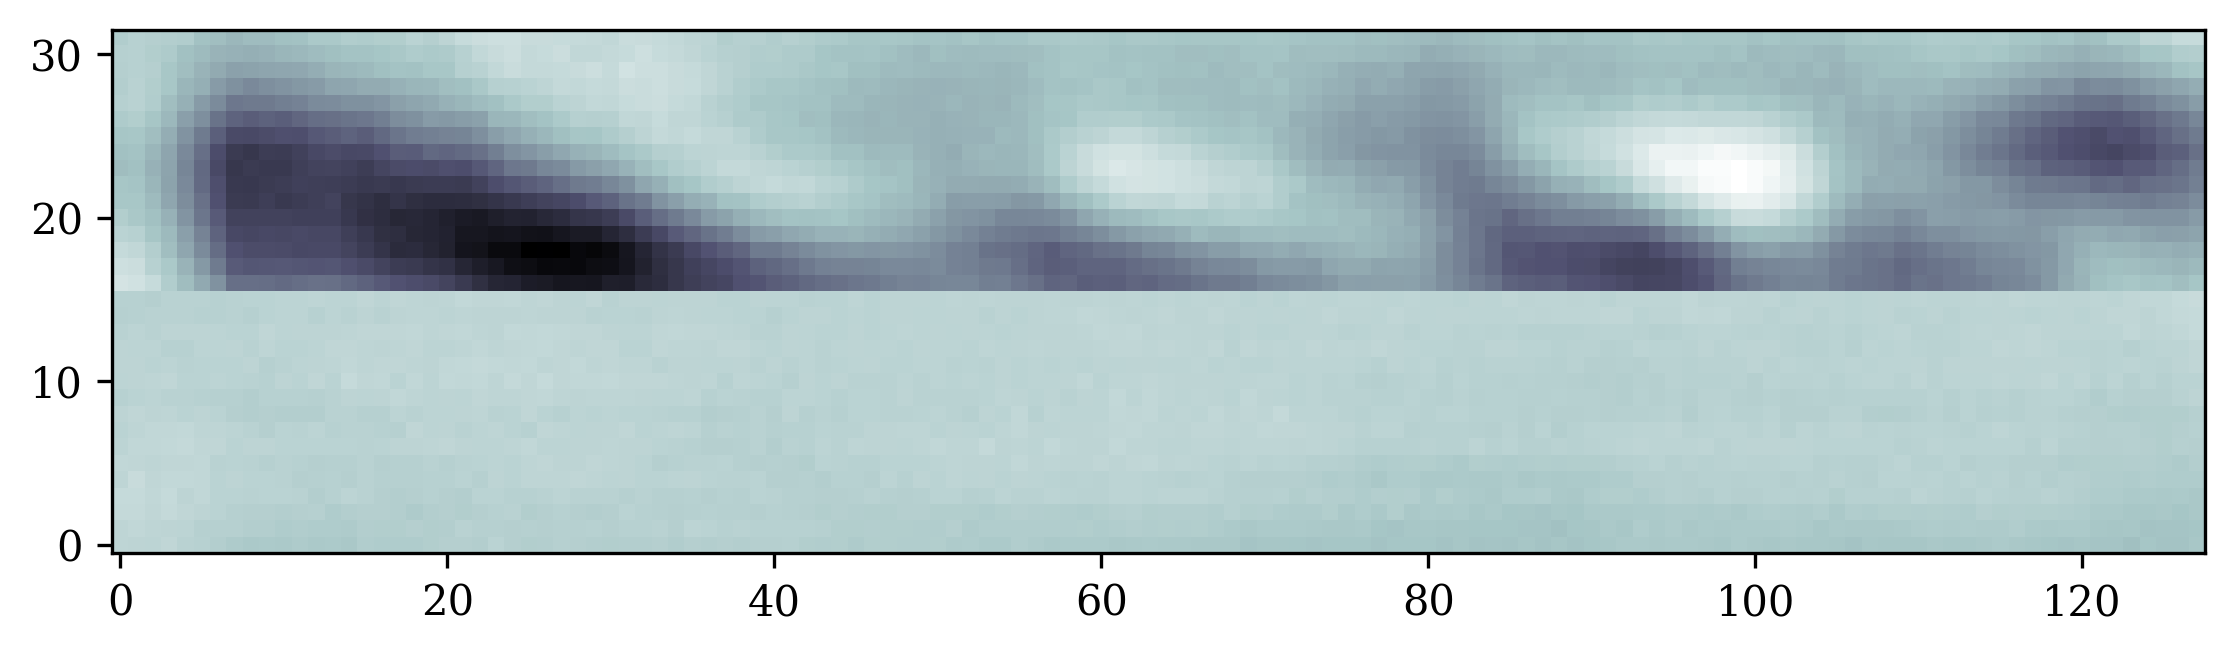

In [162]:
plt.imshow(model_pred1.cpu().numpy(),
          origin="lower",
          cmap=lc3)

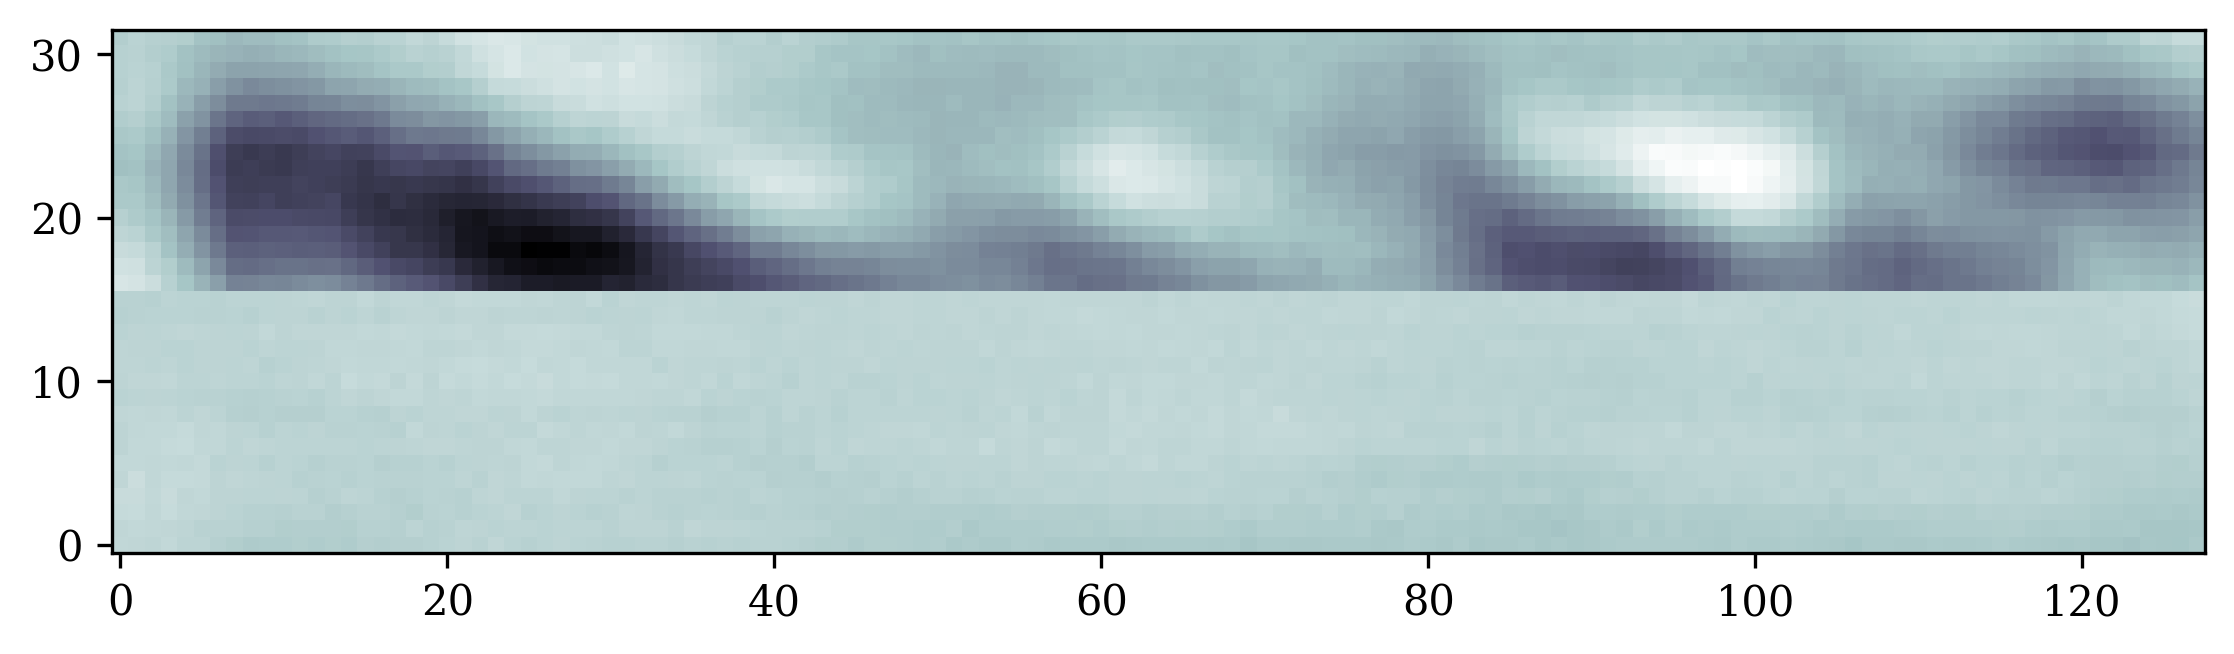

In [164]:
plt.imshow(model_pred[28, 0, :, :].cpu().numpy(),
          origin="lower",
          cmap=lc3)

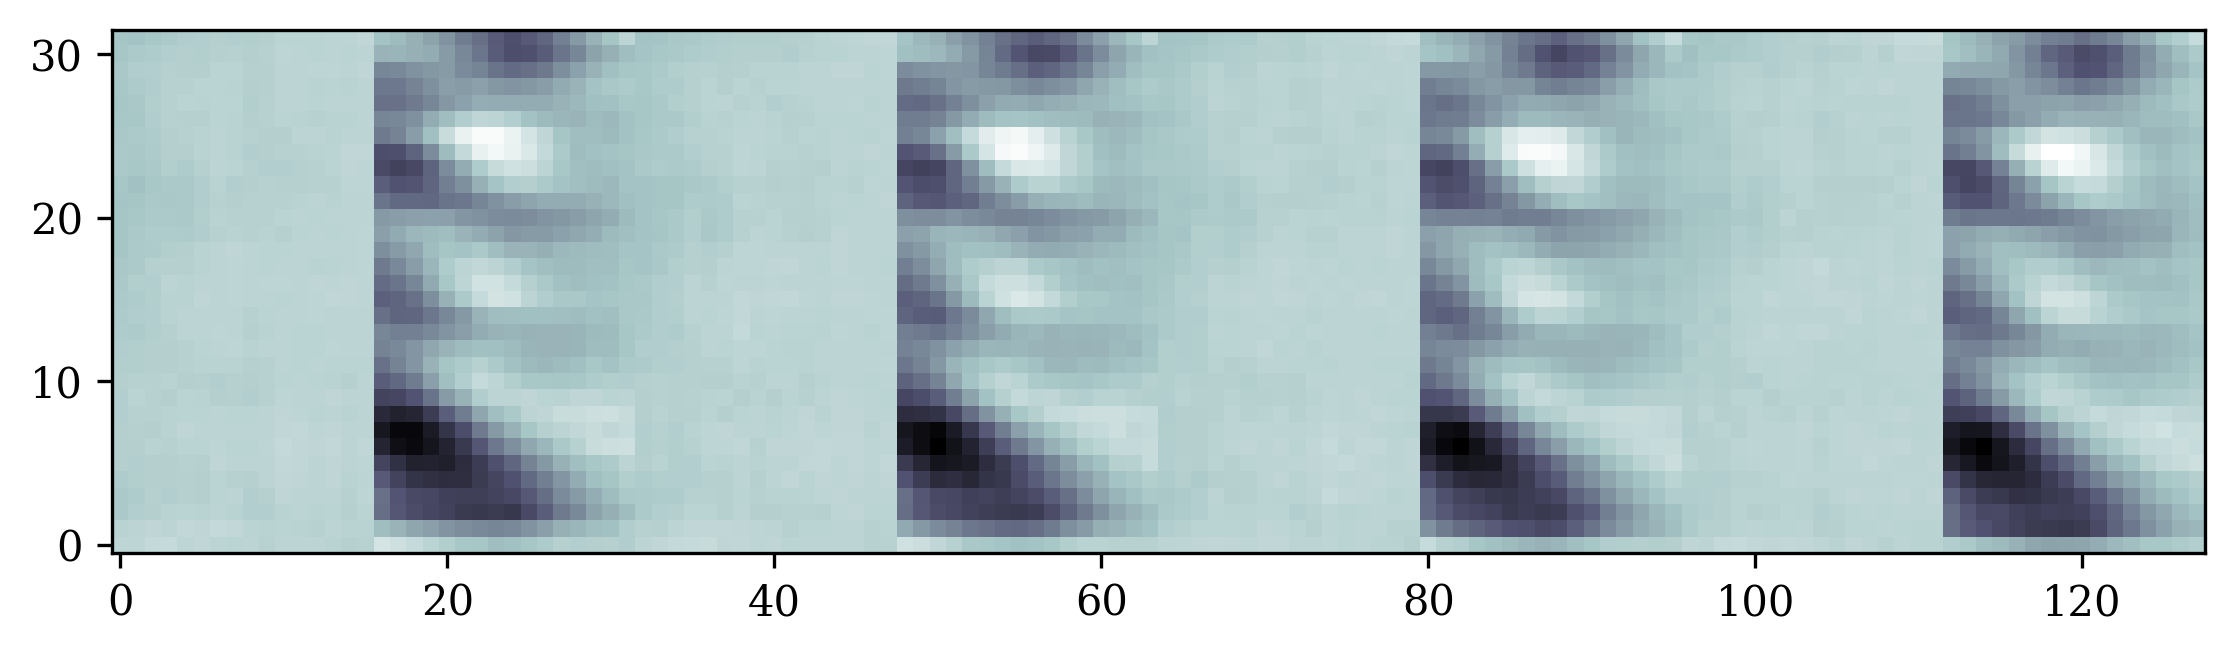

In [163]:
plt.imshow(model_pred2.cpu().numpy(),
          origin="lower",
          cmap=lc3)

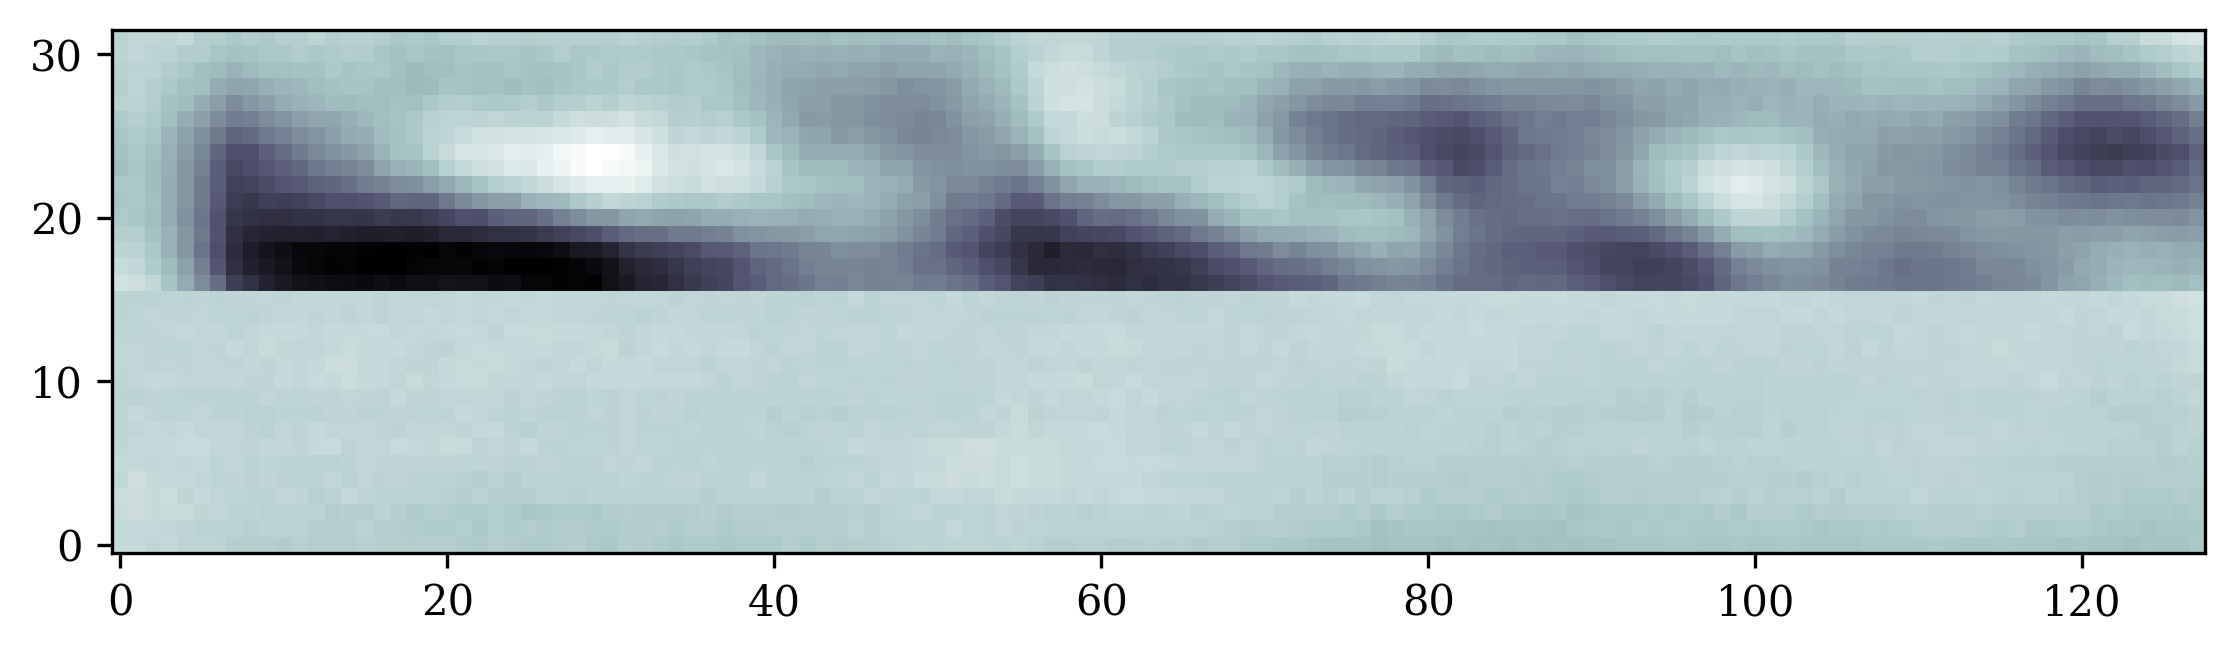

In [166]:
plt.imshow(model_pred[0, 0, :, :].cpu().numpy(),
          origin="lower",
          cmap=lc3)

In [167]:
model_pred_3 = torch.cat((model_pred[:, 0, :, 0], model_pred[:, 0, :, 1], model_pred[:, 0, :, 2]), axis=0)
model_pred_3.shape

torch.Size([132, 32])

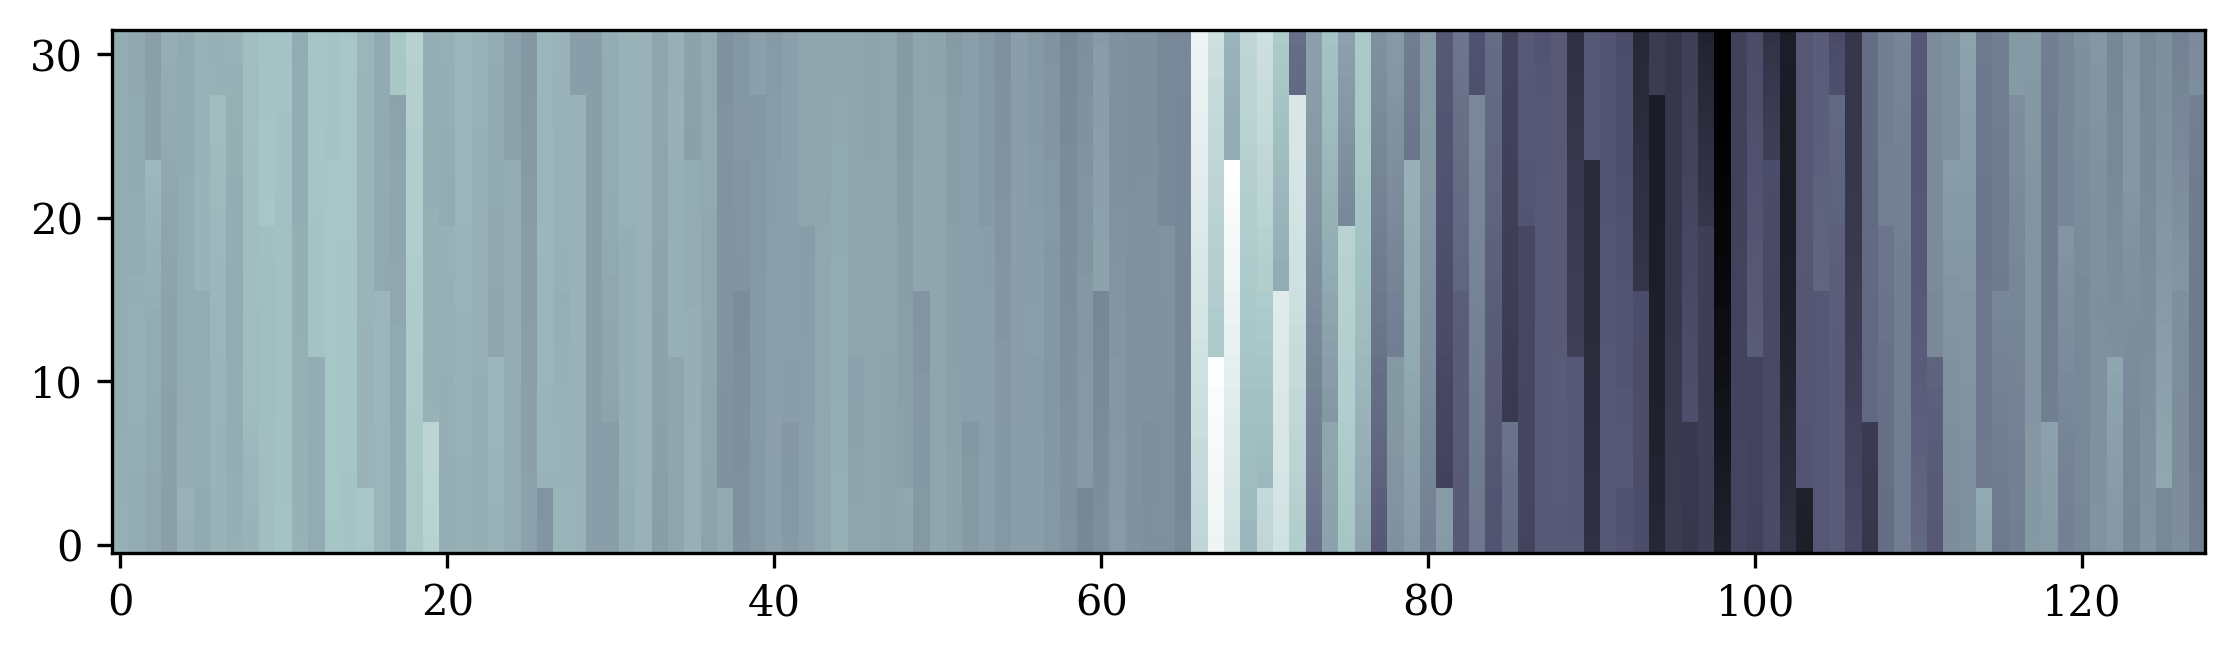

In [171]:
plt.imshow(model_pred_3.cpu().numpy().T.reshape((132, 32))[:128, :].T,
          origin="lower",
          cmap=lc3)

In [172]:
# model_pred_4 = torch.cat((model_pred[0, 0, :, :], model_pred[1, 0, :, :], model_pred[:, 0, :, 2]), axis=0)
# model_pred_3.shape

In [ ]:
# init_state.shape

In [103]:
bd["observed_data"][:, :, 4096:]

tensor([[[0.2590, 1.0000]]], device='cuda:0')

In [104]:
nbatch = bd["observed_data"].shape[0]
ntraj = bd["observed_data"].shape[1]
nseq = 4096

init_2d = init_state.reshape((ntraj * nbatch, 1, 32, 128))
init_2d.shape

torch.Size([1, 1, 32, 128])

In [105]:
zp = model2.encoder[0](init_2d)
c2d1 = model2.encoder[1](zp)
zp2 = model2.encoder[3](c2d1)
c2d2 = model2.encoder[4](zp2)
zp3 = model2.encoder[6](c2d2)
c2d3 = model2.encoder[7](zp3)
zp4 = model2.encoder[9](c2d3)
c2d4 = model2.encoder[10](zp4)
ft1 = model2.encoder[12](c2d4)
lin1 = model2.encoder[13](ft1)
lin1 = lin1.reshape((nbatch, ntraj, latent_dim))
lin1.shape

torch.Size([1, 1, 8])

In [106]:
lat_concat = torch.cat((lin1, bd["observed_data"][:, :, 4096:]), -1)

In [107]:
latstates2 = odeint(model2.pnode, lat_concat, tpredict.to(device))
print(latstates2.shape)
mlplat2 = model2.decoder_mlp(latstates2[:, :, :, :8]).reshape((44, 64, -1, 8))
mlplat2.shape

torch.Size([44, 1, 1, 10])


torch.Size([44, 64, 1, 8])

In [108]:
ntraj, nbatch, nseq, _ = latstates2.shape

In [110]:
ntraj

44

In [111]:
nbatch

1

In [112]:
nseq

1

In [109]:
# decoder loop
ct2d1 = model.decoder_conv[0](mlplat2)
ct2d2 = model.decoder_conv[2](ct2d1)
ct2d3 = model.decoder_conv[4](ct2d2)
ct2d4 = model.decoder_conv[6](ct2d3)


ct2d4.shape

torch.Size([44, 2, 16, 128])

In [124]:
x = torch.Tensor(np.linspace(1, 120, 120).reshape((5, 2, 3, 4)))
x[2, [0, 1], :, :]


tensor([[[49., 50., 51., 52.],
         [53., 54., 55., 56.],
         [57., 58., 59., 60.]],

        [[61., 62., 63., 64.],
         [65., 66., 67., 68.],
         [69., 70., 71., 72.]]])

In [125]:
y1 = x.reshape((5, 1, 6, 4))
y1[2, 0, :, :]


tensor([[49., 50., 51., 52.],
        [53., 54., 55., 56.],
        [57., 58., 59., 60.],
        [61., 62., 63., 64.],
        [65., 66., 67., 68.],
        [69., 70., 71., 72.]])

In [126]:
y2 = x.reshape((5, -1, 6, 4))
y2[2, 0, :, :]


tensor([[49., 50., 51., 52.],
        [53., 54., 55., 56.],
        [57., 58., 59., 60.],
        [61., 62., 63., 64.],
        [65., 66., 67., 68.],
        [69., 70., 71., 72.]])

In [133]:
y2[2, 0, :, :].T.reshape((6, 4))

tensor([[49., 53., 57., 61.],
        [65., 69., 50., 54.],
        [58., 62., 66., 70.],
        [51., 55., 59., 63.],
        [67., 71., 52., 56.],
        [60., 64., 68., 72.]])

In [127]:
y3 = x.reshape(5, 1, 24)
y3[2, 0, :].reshape((6, 4))

tensor([[49., 50., 51., 52.],
        [53., 54., 55., 56.],
        [57., 58., 59., 60.],
        [61., 62., 63., 64.],
        [65., 66., 67., 68.],
        [69., 70., 71., 72.]])

In [ ]:
ct2d4.shape

In [ ]:
# 88 * 64 * 32 * 2

In [ ]:
# 44 * 2 * 32 * 128

In [ ]:
# model(tpredict.to(device), bd["observed_data"]).shape